In [1]:
pretty = True
highres = True

%matplotlib inline
if highres:
    %config InlineBackend.figure_format = 'retina'
else:
    %config InlineBackend.figure_format = 'png'

#rcParams["figure.dpi"]=300

import sys
from pathlib import Path

pypsapath = "C:/dev/py/PyPSA/"

if sys.path[0] != pypsapath:
    sys.path.insert(0,pypsapath)

if Path("../..") not in [Path(p) for p in sys.path]:
    sys.path.insert(0,"../..")

%load_ext autoreload
%autoreload 2

In [2]:
import src.globals
from src.scigridnetwork import SciGRID_network
from src.armafitloader import ARMAfit_loader

Git root path found at: C:\dev\grid-analysis
Using data path:        C:\dev\grid-analysis\data


In [3]:
import pypsa
import numpy as np
import pandas as pd
import os
import itertools
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.dates
import matplotlib.font_manager
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"


from IPython.display import Markdown, display
printm = lambda s: display(Markdown(s))

In [4]:
sgn = SciGRID_network()

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.



0.13.2 ['C:/dev/py/PyPSA\\pypsa']


In [5]:
month_index = 0
month_name = ARMAfit_loader.monthnames[month_index]

solar_res_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_resdaylightcov.npy")
wind_res_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_rescov.npy")
solar_gen_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_gendaylightcov.npy")
wind_gen_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_gencov.npy")
solar_diff_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_diffdaylightcov.npy")
wind_diff_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_diffcov.npy")
solar_diff_cov_norm = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_diffdaylightcovnorm.npy")
wind_diff_cov_norm = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_diffcovnorm.npy")

In [6]:
bus_res_cov_day = wind_res_cov + solar_res_cov
bus_res_cov_night = wind_res_cov
bus_gen_cov_day = wind_gen_cov + solar_gen_cov
bus_gen_cov_night = wind_gen_cov
bus_diff_cov_day = wind_diff_cov + solar_diff_cov
bus_diff_cov_night = wind_diff_cov
bus_diff_cov_day_norm = wind_diff_cov_norm + solar_diff_cov_norm
bus_diff_cov_night_norm = wind_diff_cov_norm

bus_res_cov_solar = solar_res_cov
bus_gen_cov_solar = solar_gen_cov
bus_diff_cov_solar = solar_diff_cov

In [7]:
line_res_cov_day = sgn.F @ bus_res_cov_day @ sgn.F.T
line_res_cov_night = sgn.F @ bus_res_cov_night @ sgn.F.T
line_gen_cov_day = sgn.F @ bus_gen_cov_day @ sgn.F.T
line_gen_cov_night = sgn.F @ bus_gen_cov_night @ sgn.F.T
line_diff_cov_day = sgn.F @ bus_diff_cov_day @ sgn.F.T
line_diff_cov_night = sgn.F @ bus_diff_cov_night @ sgn.F.T

line_res_cov_solar = sgn.F @ bus_res_cov_solar @ sgn.F.T
line_gen_cov_solar = sgn.F @ bus_gen_cov_solar @ sgn.F.T
line_diff_cov_solar = sgn.F @ bus_diff_cov_solar @ sgn.F.T

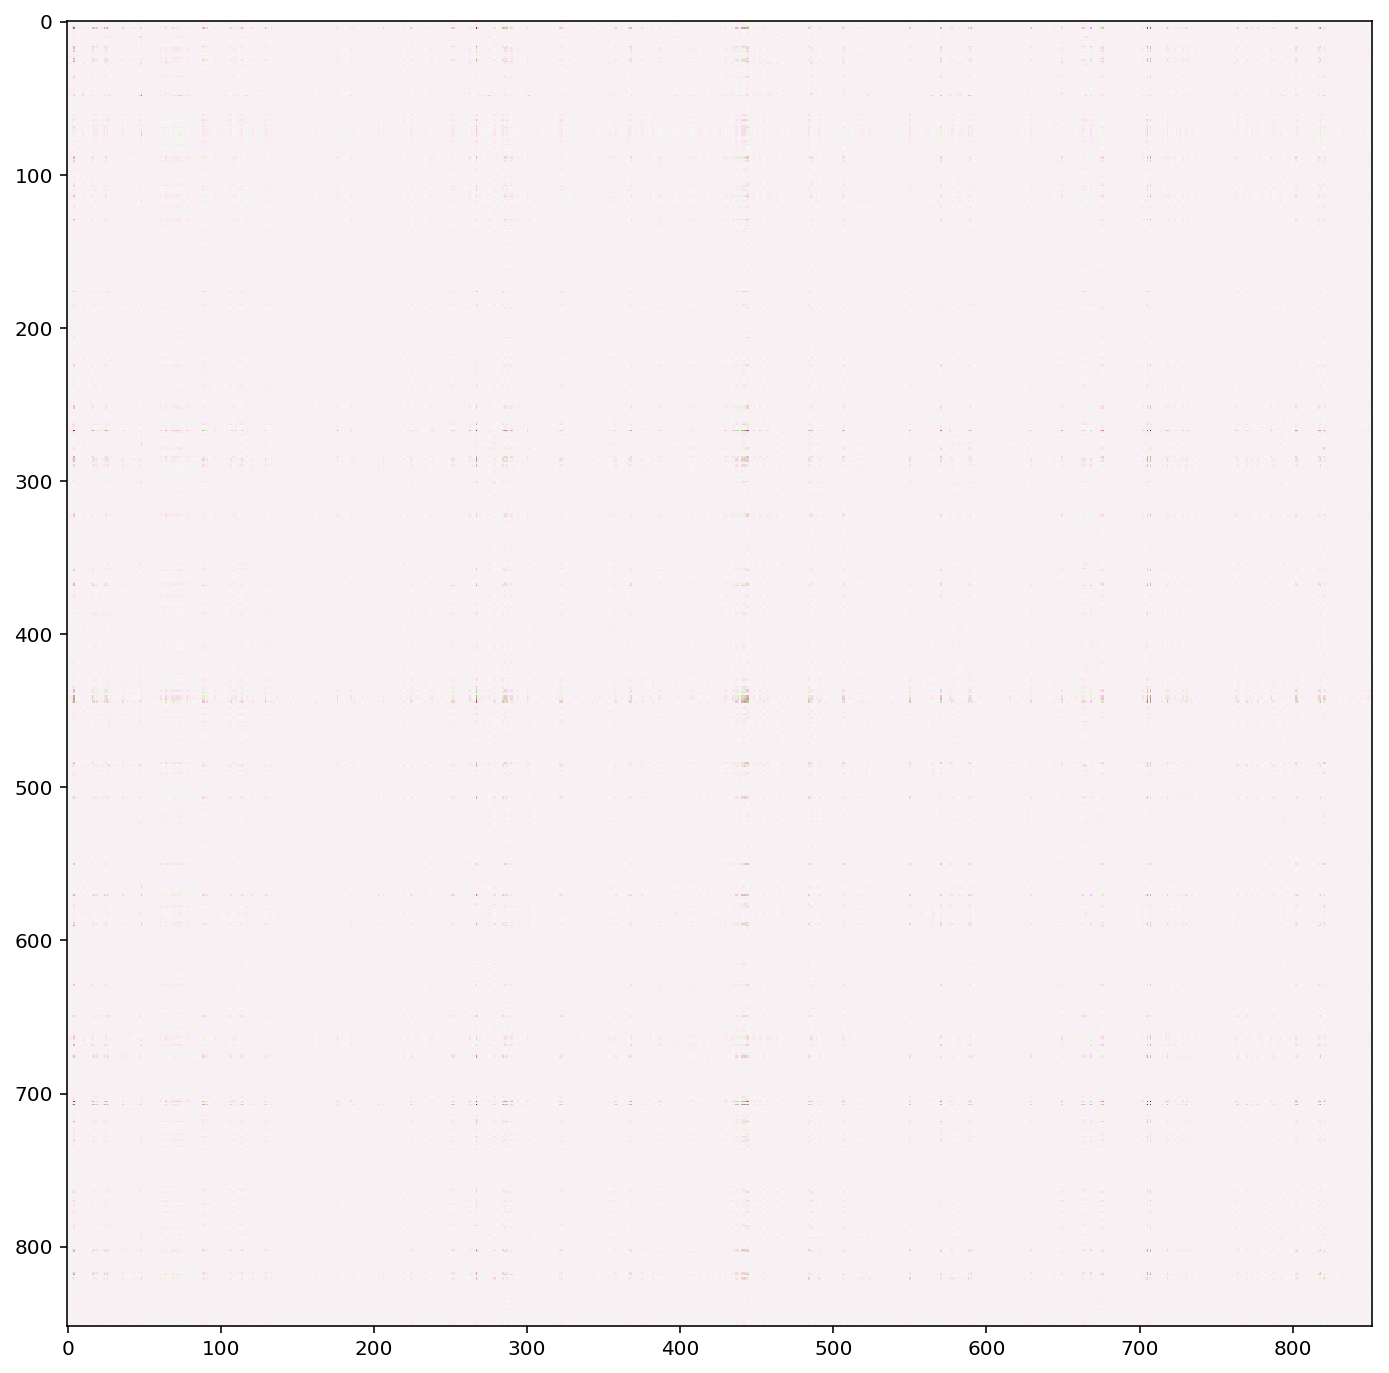

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(line_gen_cov_day, cmap="PiYG")

In [9]:
sgn.network.generators.p_nom.describe()

count    1.423000e+03
mean     1.212513e+02
std      2.833683e+02
min      2.147047e-08
25%      1.117244e+01
50%      3.872489e+01
75%      1.075388e+02
max      4.730000e+03
Name: p_nom, dtype: float64

In [10]:
des = lambda x: pd.Series(x).describe()

des(np.sqrt(np.diagonal(line_diff_cov_day)))

count    852.000000
mean      42.136190
std       48.974580
min        0.110106
25%        8.758967
50%       22.040452
75%       60.075983
max      433.210799
dtype: float64

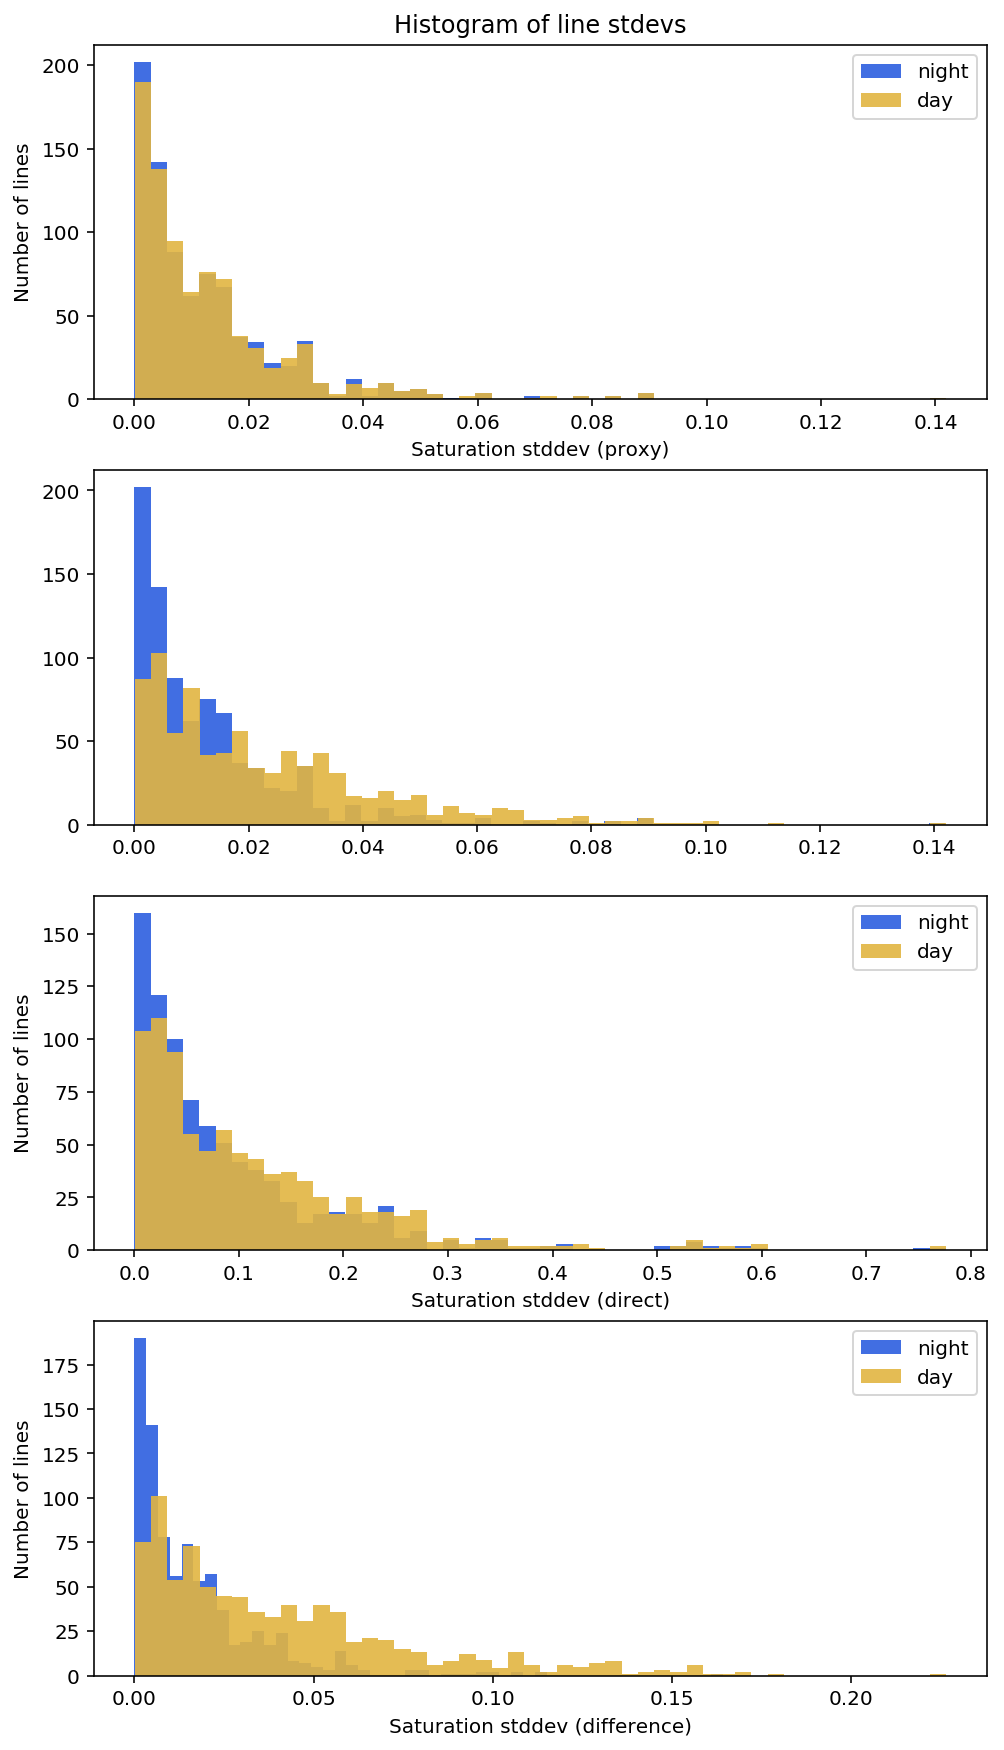

In [11]:
fig, ax = plt.subplots(4,1,figsize=(8,15))
#plt.subplots_adjust(hspace=.3)

ax[0].hist(np.sqrt(np.diagonal(line_res_cov_night)) / sgn.line_threshold, bins=50, color=src.globals.wind_color, label="night")
ax[0].hist(np.sqrt(np.diagonal(line_res_cov_day)) / sgn.line_threshold, bins=50, color=src.globals.solar_color, label="day", alpha=.9)

ax[1].hist(np.sqrt(np.diagonal(line_res_cov_night)) / sgn.line_threshold, bins=50, color=src.globals.wind_color, label="night")
ax[1].hist(np.sqrt(np.diagonal(line_res_cov_night + 0.1 * line_gen_cov_solar)) / sgn.line_threshold, bins=50, color=src.globals.solar_color, label="day", alpha=.9)

ax[2].hist(np.sqrt(np.diagonal(line_gen_cov_night)) / sgn.line_threshold, bins=50, color=src.globals.wind_color, label="night")
ax[2].hist(np.sqrt(np.diagonal(line_gen_cov_day)) / sgn.line_threshold, bins=50, color=src.globals.solar_color, label="day", alpha=.9)

ax[3].hist(np.sqrt(np.diagonal(line_diff_cov_night)) / sgn.line_threshold, bins=50, color=src.globals.wind_color, label="night")
ax[3].hist(np.sqrt(np.diagonal(line_diff_cov_day)) / sgn.line_threshold, bins=50, color=src.globals.solar_color, label="day", alpha=.9)



ax[0].set_title("Histogram of line stdevs")
ax[0].set_xlabel("Saturation stddev (proxy)")
ax[0].set_ylabel("Number of lines")
ax[0].legend()

#ax[2].set_title("Histogram of line stdevs (direct)")
ax[2].set_xlabel("Saturation stddev (direct)")
ax[2].set_ylabel("Number of lines")
ax[2].legend()

#ax[3].set_title("Histogram of line stdevs (difference)")
ax[3].set_xlabel("Saturation stddev (difference)")
ax[3].set_ylabel("Number of lines")
ax[3].legend()

In [12]:
describeshort = lambda series: printm("|range | mean | \n |---|---| \n | $[{0:.6f},{1:.6f}]$ | ${2:.4f}$ |".format(np.min(series), np.max(series), np.mean(series)))

printm("# Proxy")
printm("During daytime:")
describeshort(np.sqrt(np.diagonal(line_res_cov_day)) / sgn.line_threshold)
printm("_Alt 1_: Night residues, 25% differences")
describeshort((np.sqrt(np.diagonal(line_res_cov_night) + .25*np.diagonal(line_diff_cov_solar))) / sgn.line_threshold)
printm("_Alt 2_: Night residues, 10% direct")
describeshort((np.sqrt(np.diagonal(line_res_cov_night) + .1*np.diagonal(line_gen_cov_solar))) / sgn.line_threshold)

printm("During nighttime:")
describeshort(np.sqrt(np.diagonal(line_res_cov_night)) / sgn.line_threshold)

printm("# Direct")
printm("During daytime:")
describeshort(np.sqrt(np.diagonal(line_gen_cov_day)) / sgn.line_threshold)

printm("During nighttime:")
describeshort(np.sqrt(np.diagonal(line_gen_cov_night)) / sgn.line_threshold)

printm("# Differences")
printm("During daytime:")
describeshort(np.sqrt(np.diagonal(line_diff_cov_day)) / sgn.line_threshold)

printm("During nighttime:")
describeshort(np.sqrt(np.diagonal(line_diff_cov_night)) / sgn.line_threshold)

# Proxy

During daytime:

|range | mean | 
 |---|---| 
 | $[0.000022,0.141859]$ | $0.0133$ |

_Alt 1_: Night residues, 25% differences

|range | mean | 
 |---|---| 
 | $[0.000058,0.142089]$ | $0.0232$ |

_Alt 2_: Night residues, 10% direct

|range | mean | 
 |---|---| 
 | $[0.000048,0.142088]$ | $0.0231$ |

During nighttime:

|range | mean | 
 |---|---| 
 | $[0.000013,0.141857]$ | $0.0130$ |

# Direct

During daytime:

|range | mean | 
 |---|---| 
 | $[0.000177,0.776427]$ | $0.1128$ |

During nighttime:

|range | mean | 
 |---|---| 
 | $[0.000100,0.776005]$ | $0.0912$ |

# Differences

During daytime:

|range | mean | 
 |---|---| 
 | $[0.000111,0.226463]$ | $0.0405$ |

During nighttime:

|range | mean | 
 |---|---| 
 | $[0.000017,0.164237]$ | $0.0167$ |

In [13]:
armafits = ARMAfit_loader(sgn)

In [14]:
# sgn_fullyear = SciGRID_network()
# sgn_fullyear.network.generators_t.p_max_pu
# sgn2.network.generators_t.p_max_pu

In [15]:
printm("## `sgn`:")
printm("Average national solar generation: {0:.0f} MW".format(armafits.solar_generationmonth.sum(axis=0).mean()))
printm("Average national wind generation: {0:.0f} MW".format(armafits.wind_generationmonth.sum(axis=0).mean()))

## `sgn`:

Average national solar generation: 3170 MW

Average national wind generation: 10805 MW

In [16]:
sgn2= SciGRID_network(Path(pypsapath) / "examples" / "scigrid-de" / "scigrid-with-load-gen-trafos")
armafits2 = ARMAfit_loader(sgn2)

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.



0.13.2 ['C:/dev/py/PyPSA\\pypsa']


In [17]:
printm("## `sgn2`:")
printm("Average national solar generation: {0:.0f} MW".format(armafits2.solar_generationmonth.sum(axis=0).mean()))
printm("Average national wind generation: {0:.0f} MW".format(armafits2.wind_generationmonth.sum(axis=0).mean()))

## `sgn2`:

Average national solar generation: 1975 MW

Average national wind generation: 22621 MW

In [18]:
sgn_jan1 = sgn.solar_generation[:,:24]
sgn2_jan1 = sgn2.solar_generation[:,:24]
coincide = np.all(sgn_jan1 == sgn2_jan1)

printm("`sgn` and `sgn2` **{}** coincide on January 1, 2011.".format("DO" if coincide else "DO NOT"))

`sgn` and `sgn2` **DO** coincide on January 1, 2011.

# 🌼

In [19]:
sgn.run_lopf_jan1()

Performing linear OPF for one day, 4 snapshots at a time:


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:47<00:00,  7.67s/it]


In [20]:
sgn2.run_lopf_jan1()

Performing linear OPF for one day, 4 snapshots at a time:


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:46<00:00,  7.90s/it]


In [21]:
# No difference:
sgn3.network.storage_units = sgn.network.storage_units
sgn3.network.storage_units_t = sgn.network.storage_units_t

# No difference:
sgn3.network.transformers = sgn.network.transformers
sgn3.network.transformers_t = sgn.network.transformers_t
sgn3.network.transformer_types = sgn.network.transformer_types
sgn3.network.transformer_types_t = sgn.network.transformer_types_t

# DOES make a difference:
sgn3.network.lines = sgn.network.lines
sgn3.network.lines_t = sgn.network.lines_t
sgn3.network.line_types = sgn.network.line_types
sgn3.network.line_types_t = sgn.network.line_types_t

# 
sgn3.network.links = sgn.network.links
sgn3.network.links_t = sgn.network.links_t

# sgn3.run_lopf_jan1()

NameError: name 'sgn3' is not defined

In [26]:
sgn3_line_flow_jan1 = sgn3.line_flow_linear.values
sgn2_line_flow_jan1 = sgn2.line_flow_linear.values
coincide_line_flow = np.all(sgn3_line_flow_jan1 == sgn2_line_flow_jan1)

printm("`sgn3` and `sgn2` line flows **{}** coincide on January 1, 2011.".format("DO" if coincide_line_flow else "DO NOT"))

NameError: name 'sgn3' is not defined

In [23]:
sgn3_line_flow_jan1 = sgn3.line_flow_linear.values
sgn_line_flow_jan1 = sgn.line_flow_linear.values
coincide_line_flow = np.all(sgn3_line_flow_jan1 == sgn_line_flow_jan1)

printm("`sgn3` and `sgn` line flows **{}** coincide on January 1, 2011.".format("DO" if coincide_line_flow else "DO NOT"))

NameError: name 'sgn3' is not defined

In [27]:
sgn2_line_flow_jan1 = sgn2.line_flow_linear.values
sgn_line_flow_jan1 = sgn.line_flow_linear.values
coincide_line_flow = np.all(sgn2_line_flow_jan1 == sgn_line_flow_jan1)

printm("`sgn2` and `sgn` line flows **{}** coincide on January 1, 2011.".format("DO" if coincide_line_flow else "DO NOT"))

`sgn2` and `sgn` line flows **DO NOT** coincide on January 1, 2011.

In [28]:
# sgn3.network.loads_t.p

In [29]:
# 100*(sgn2.line_flow_total - sgn.line_flow_total) / sgn2.line_flow_total

# 🌷

In [30]:
fav_sgn = sgn

In [36]:
elevenAM = fav_sgn.network.generators_t.p.index[11]

print(f"Total load: {fav_sgn.network.loads_t.p_set.loc[elevenAM,:].sum()} MW")
print(f"Total generation: {fav_sgn.network.generators_t.p.loc[elevenAM,:].sum()} MW")
print(f"Generation overshoot: {fav_sgn.injection_total.loc[elevenAM,:].sum()} MW")

Total load: 52524.64000000083 MW
Total generation: 52950.84000000398 MW
Generation overshoot: 426.20000000314803 MW


In [37]:
#pd.Series(sgn2.line_saturation_total.values[11])
#sgn2.network.lines_t.p1.values[11]# / sgn2.network.lines.s_nom
#sgn2.line_flow_total

In [38]:
f = fav_sgn.line_saturation_nonlinear.values[11,:]

def true_prob(mu, sigma):
    return 1.0 - (scipy.stats.norm.cdf(1.0, loc=mu, scale=sigma) - scipy.stats.norm.cdf(-1.0, loc=mu, scale=sigma))

def rate(mu, sigma):
    return np.square(1-np.abs(mu))/(2.0*np.square(sigma))

line_ratings = pd.DataFrame({"l":fav_sgn.network.lines.index.values,
              "f": f,
              "σres_day": np.sqrt(np.diagonal(line_res_cov_day)) / fav_sgn.line_threshold,
              "σalt1_day": (np.sqrt(np.diagonal(line_res_cov_night) + .25*np.diagonal(line_diff_cov_solar))) / fav_sgn.line_threshold,
              "σgen_day": np.sqrt(np.diagonal(line_gen_cov_day)) / fav_sgn.line_threshold,
              "σdiff_day": np.sqrt(np.diagonal(line_diff_cov_day)) / fav_sgn.line_threshold})

sigmaepsilon = 1
line_ratings["P>1"] = true_prob(line_ratings.f, line_ratings.σdiff_day*sigmaepsilon)
line_ratings["rate"] = rate(line_ratings.f, line_ratings.σdiff_day*sigmaepsilon)

line_ratings["Pnorm"] = line_ratings["P>1"] / np.max(line_ratings["P>1"])

line_ratings.sort_values("P>1", ascending=False).head(20)

l         f  σres_day  σalt1_day  σgen_day  σdiff_day       P>1  \
358  361 -0.700000  0.141859   0.142089  0.776427   0.165036  0.034548   
512  516 -0.700000  0.015370   0.079814  0.277123   0.158361  0.029085   
582  586  0.700000  0.050059   0.088067  0.336810   0.156279  0.027451   
583  587  0.699713  0.050038   0.088031  0.336672   0.156215  0.027286   
796  803 -0.700000  0.014954   0.073708  0.240863   0.146402  0.020223   
663  670 -0.700000  0.090318   0.095874  0.765217   0.133020  0.012057   
18    19 -0.700000  0.070680   0.086294  0.444412   0.131519  0.011273   
301  302 -0.698663  0.008983   0.065763  0.198040   0.131094  0.010763   
47    48 -0.699312  0.037957   0.071196  0.296875   0.129811  0.010269   
550  554 -0.643143  0.042347   0.082347  0.396779   0.152758  0.009743   
484  488 -0.643028  0.042339   0.082332  0.396708   0.152730  0.009713   
802  809  0.700000  0.057399   0.074832  0.546505   0.125097  0.008239   
27    28 -0.700000  0.034675   0.067190  0.275279   0.123281  0.007478   
803  810 -0.681245  0.056958   0.077003  0.536026   0.130472  0.007281   
28    29  0.689670  0.032507   0.063627  0.255721   0.116877  0.003963   
26    27 -0.700000  0.073569   0.079274  0.578278   0.111453  0.003554   
386  389  0.700000  0.089249   0.089630  0.541789   0.106736  0.002472   
387  390  0.699828  0.089227   0.089608  0.541656   0.106710  0.002454   
483  486 -0.700000  0.007459   0.053210  0.174304   0.106118  0.002349   
248  249 -0.700000  0.019099   0.048334  0.196441   0.092181  0.000568   

         rate     Pnorm  
358  1.652178  1.000000  
512  1.794393  0.841877  
582  1.842515  0.794585  
583  1.847559  0.789794  
796  2.099520  0.585369  
663  2.543194  0.348996  
18   2.601575  0.326298  
301  2.641853  0.311534  
47   2.682752  0.297249  
550  2.728687  0.282010  
484  2.731415  0.281131  
802  2.875516  0.238492  
27   2.960855  0.216443  
803  2.984334  0.210753  
28   3.525030  0.114713  
26   3.622641  0.102882  
386  3.949923  0.071551  
387  3.956381  0.071042  
483  3.996093  0.067991  
248  5.295785  0.016441

In [83]:
line_ratings_reindexed = line_ratings.set_index("l")

#line_ratings_reindexed.sort_values("P>1", ascending=False)

#line_ratings["P>1"]

fav_sgn.injection_total.loc[elevenAM,:].describe()

count     489.000000
mean        0.871575
std       261.882919
min     -1283.084288
25%       -88.445342
50%       -35.090385
75%        18.226190
max      2396.446910
Name: 2011-01-01 11:00:00, dtype: float64

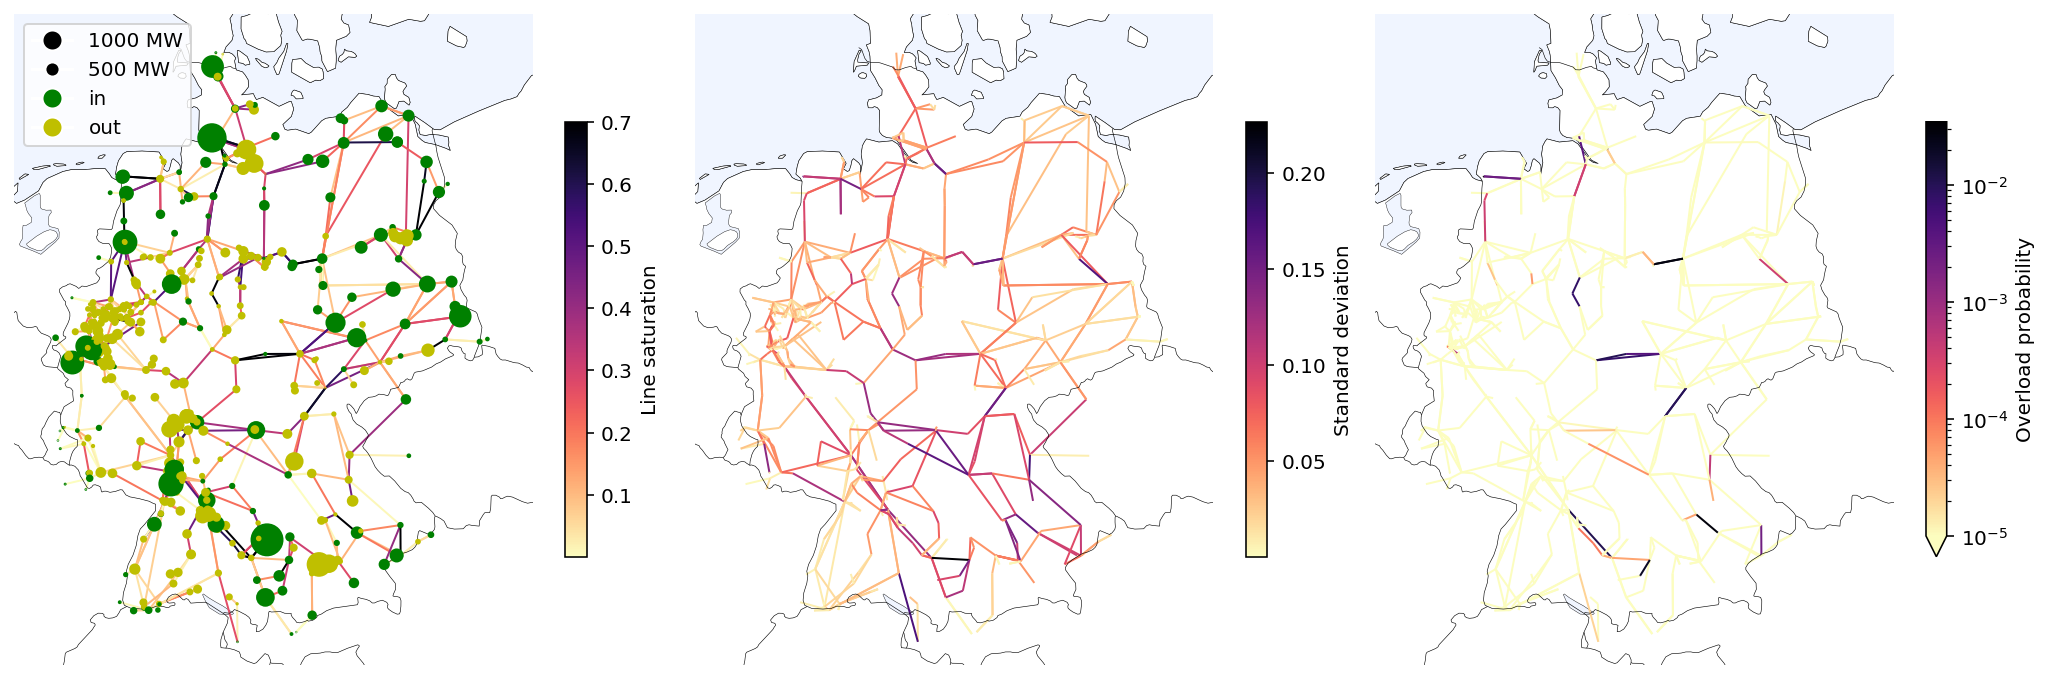

In [90]:
fig = plt.figure(figsize=(18,8))
import cartopy.crs as ccrs 
ax = fig.subplots(1,3,subplot_kw={"projection":ccrs.TransverseMercator(central_longitude=10.0, central_latitude=50.0)}).flatten()

geomap = "50m"


import cartopy.feature

bus_sizes = [0]*len(fav_sgn.network.buses)
bus_colors = ['g']*len(fav_sgn.network.buses)

for i, bus_name in enumerate(fav_sgn.network.buses.index):
    if bus_name in fav_sgn.new_nodes:
        powerinj = (fav_sgn.injection_total.loc[elevenAM,:])[fav_sgn.node_index(bus_name)]
        bus_sizes[i] = np.abs(powerinj) / 10
        bus_colors[i] = 'g' if powerinj > 0 else 'y'

#bus_sizes = 0.0

line_colors_flow = [np.abs(line_ratings_reindexed["f"][i]) for i in fav_sgn.network.lines.index]
line_colors_std = [line_ratings_reindexed["σdiff_day"][i] for i in fav_sgn.network.lines.index]
line_colors_prob = [line_ratings_reindexed["P>1"][i]+1e-5 for i in fav_sgn.network.lines.index]

line_widths=1


pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors_flow, line_widths=line_widths, line_cmap="magma_r", ax=ax[0])
cbar = fig.colorbar(linecol, ax=ax[0], shrink=.5)
cbar.set_label("Line saturation")

import matplotlib.lines
legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='1 MW in',
                          markerfacecolor='g', markersize=(1000/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='0.5 MW in',
                          markerfacecolor='g', markersize=(500/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='1 MW out',
                          markerfacecolor='y', markersize=(1000/10)**0.5)]
legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='1000 MW',
                          markerfacecolor='0', markersize=(1000/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='500 MW',
                          markerfacecolor='0', markersize=(500/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='in',
                          markerfacecolor='g', markersize=(1000/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='out',
                          markerfacecolor='y', markersize=(1000/10)**0.5)]

ax[0].legend(handles=legend_elements)

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=0, bus_colors="#ffffff00", line_colors=line_colors_std, line_widths=line_widths, line_cmap="magma_r", branch_components=['Line'], ax=ax[1])
cbar = fig.colorbar(linecol, ax=ax[1], shrink=.5)
cbar.set_label("Standard deviation")


pathcol, linecol = fav_sgn.network.plot(geomap=True, bus_sizes=0, bus_colors="#ffffff00", line_colors=line_colors_prob, line_widths=line_widths, line_cmap="magma_r", ax=ax[2])
linecol.norm = matplotlib.colors.LogNorm()
cbar = fig.colorbar(linecol, ax=ax[2], extend="min", shrink=.5)
cbar.set_label("Overload probability")


for axi in ax:
    axi.add_feature(cartopy.feature.LAKES.with_scale(geomap), facecolor="#f0f5ff", edgecolor="#000000", linewidth=.2, zorder=.5)
    axi.add_feature(cartopy.feature.LAND.with_scale(geomap), facecolor="#ffffff", edgecolor="#000000", linewidth=.2)
    axi.background_patch.set_facecolor("#f0f5ff")

plt.subplots_adjust(wspace=.05)

plt.savefig("nomflow_stdev_trueoverloadprob.pdf", bbox_inches="tight")

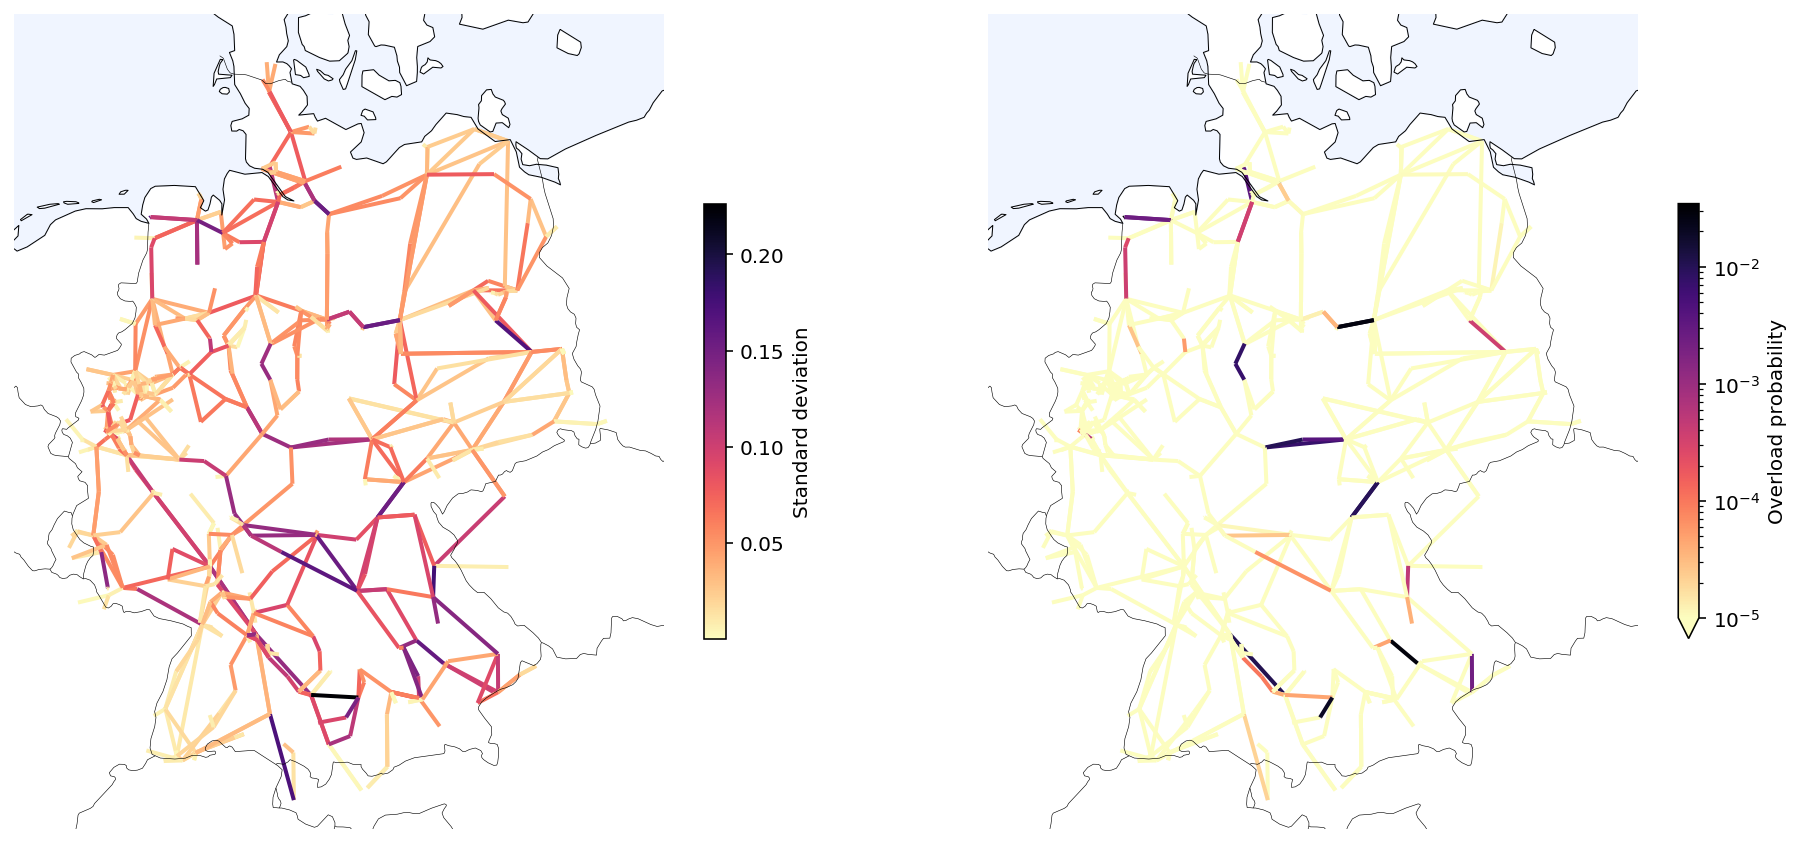

In [54]:
fig = plt.figure(figsize=(16,8))
import cartopy.crs as ccrs
import cartopy.feature
ax = fig.subplots(1,2,subplot_kw={"projection":ccrs.TransverseMercator(central_longitude=10.0, central_latitude=50.0)}).flatten()

bus_sizes = [0]*len(fav_sgn.network.buses)
bus_colors = ['g']*len(fav_sgn.network.buses)

for i, bus_name in enumerate(fav_sgn.network.buses.index):
    if bus_name in fav_sgn.new_nodes:
        powerinj = (fav_sgn.injection_total.loc[elevenAM,:])[fav_sgn.node_index(bus_name)]
        bus_sizes[i] = np.abs(powerinj) / 10
        bus_colors[i] = 'g' if powerinj > 0 else 'y'

#bus_sizes = 0.0

line_colors_std = [line_ratings_reindexed["σdiff_day"][i] for i in fav_sgn.network.lines.index]
line_colors_flow = [np.abs(line_ratings_reindexed["f"][i]) for i in fav_sgn.network.lines.index]

geomap = "50m"

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=0, line_colors=line_colors_std, line_cmap="magma_r", ax=ax[0])
#fav_sgn.network.plot(basemap=True, bus_sizes=0, line_colors=range(fav_sgn.m), line_cmap="magma_r")

#linecol.norm = matplotlib.colors.LogNorm()
cbar = fig.colorbar(linecol, ax=ax[0], shrink=.5)
cbar.set_label("Standard deviation")

ax[0].add_feature(cartopy.feature.OCEAN.with_scale(geomap), facecolor="#f0f5ff")
ax[0].add_feature(cartopy.feature.COASTLINE.with_scale(geomap), linewidth=0.5)

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=0, line_colors=line_colors_prob, line_cmap="magma_r", ax=ax[1])

linecol.norm = matplotlib.colors.LogNorm()
cbar = fig.colorbar(linecol, ax=ax[1], extend="min", shrink=.5)
cbar.set_label("Overload probability")

ax[1].add_feature(cartopy.feature.OCEAN.with_scale(geomap), facecolor="#f0f5ff")
ax[1].add_feature(cartopy.feature.COASTLINE.with_scale(geomap), linewidth=0.5)

In [740]:
sortedhead = line_ratings.sort_values("P>1", ascending=False).head(20)

sortedhead.index = sortedhead.l
#sortedhead.index.name = "$l$"
#sortedhead[r"$\mathbb{P}\left[ \| f \| > 1\right]$"] = sortedhead["P>1"]

def prob_format(x):
    s = "{:#.3g}".format(np.abs(x)*100)
    s = s[:5]
    s += " " * (5-len(s))
    return s + "%"

sortedhead["fpercent"] = ["{:.0f}%".format(np.abs(x)*100) for x in sortedhead["f"]]
sortedhead["Ppercent"] = [prob_format(x) for x in sortedhead["P>1"]]
sortedhead["rate"] = ["{:#.3g}".format(x) for x in sortedhead["rate"]]


#sortedhead[["fpercent", "Ppercent", "rate"]].to_latex(src.globals.data_path / "processed" / "top20lines.tex")
#sortedhead[["Ppercent", "rate"]].to_latex(src.globals.data_path / "processed" / "top20lines.tex")


sortedhead

l         f  σres_day  σalt1_day  σgen_day  σdiff_day       P>1  rate  \
l                                                                              
361  361 -0.700000  0.141859   0.142089  0.776427   0.165036  0.034548  1.65   
516  516 -0.700000  0.015370   0.079814  0.277123   0.158361  0.029085  1.79   
586  586  0.700000  0.050059   0.088067  0.336810   0.156279  0.027451  1.84   
587  587  0.699713  0.050038   0.088031  0.336672   0.156215  0.027286  1.85   
803  803 -0.700000  0.014954   0.073708  0.240863   0.146402  0.020223  2.10   
670  670 -0.700000  0.090318   0.095874  0.765217   0.133020  0.012057  2.54   
19    19 -0.700000  0.070680   0.086294  0.444412   0.131519  0.011273  2.60   
302  302 -0.698663  0.008983   0.065763  0.198040   0.131094  0.010763  2.64   
48    48 -0.699312  0.037957   0.071196  0.296875   0.129811  0.010269  2.68   
554  554 -0.643143  0.042347   0.082347  0.396779   0.152758  0.009743  2.73   
488  488 -0.643028  0.042339   0.082332  0.396708   0.152730  0.009713  2.73   
809  809  0.700000  0.057399   0.074832  0.546505   0.125097  0.008239  2.88   
28    28 -0.700000  0.034675   0.067190  0.275279   0.123281  0.007478  2.96   
810  810 -0.681245  0.056958   0.077003  0.536026   0.130472  0.007281  2.98   
29    29  0.689670  0.032507   0.063627  0.255721   0.116877  0.003963  3.53   
27    27 -0.700000  0.073569   0.079274  0.578278   0.111453  0.003554  3.62   
389  389  0.700000  0.089249   0.089630  0.541789   0.106736  0.002472  3.95   
390  390  0.699828  0.089227   0.089608  0.541656   0.106710  0.002454  3.96   
486  486 -0.700000  0.007459   0.053210  0.174304   0.106118  0.002349  4.00   
249  249 -0.700000  0.019099   0.048334  0.196441   0.092181  0.000568  5.30   

        Pnorm fpercent Ppercent  
l                                
361  1.000000      70%   3.45 %  
516  0.841877      70%   2.91 %  
586  0.794585      70%   2.75 %  
587  0.789794      70%   2.73 %  
803  0.585369      70%   2.02 %  
670  0.348996      70%   1.21 %  
19   0.326298      70%   1.13 %  
302  0.311534      70%   1.08 %  
48   0.297249      70%   1.03 %  
554  0.282010      64%   0.974%  
488  0.281131      64%   0.971%  
809  0.238492      70%   0.824%  
28   0.216443      70%   0.748%  
810  0.210753      68%   0.728%  
29   0.114713      69%   0.396%  
27   0.102882      70%   0.355%  
389  0.071551      70%   0.247%  
390  0.071042      70%   0.245%  
486  0.067991      70%   0.235%  
249  0.016441      70%   0.056%

In [ ]:
fig, ax = plt.subplots()

p = line_ratings["P>1"]
_=ax.hist(p[p>0], bins=100)

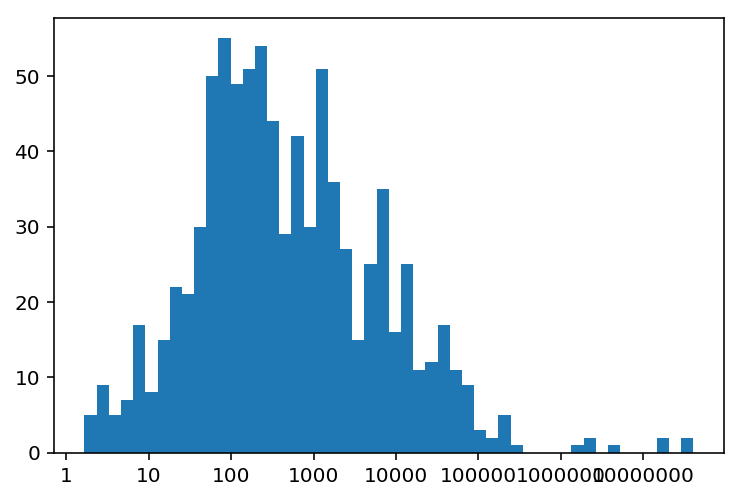

In [316]:
fig, ax = plt.subplots()

rate = line_ratings["rate"]
#_=ax.hist(rate[rate<2000], bins=50)
_=ax.hist(np.log(rate)/np.log(10), bins=50)

import matplotlib.ticker

ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: str(int(10**x))))

Text(0, 0.5, 'rate')

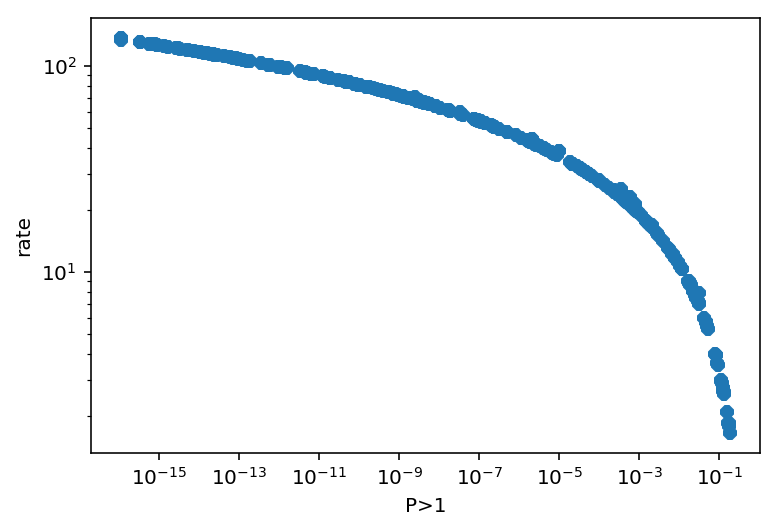

In [317]:
fig, ax = plt.subplots()


ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(p[p>0], rate[p>0], "8")
ax.set_xlabel("P>1")
ax.set_ylabel("rate")



Text(0, 0.5, 'P>1')

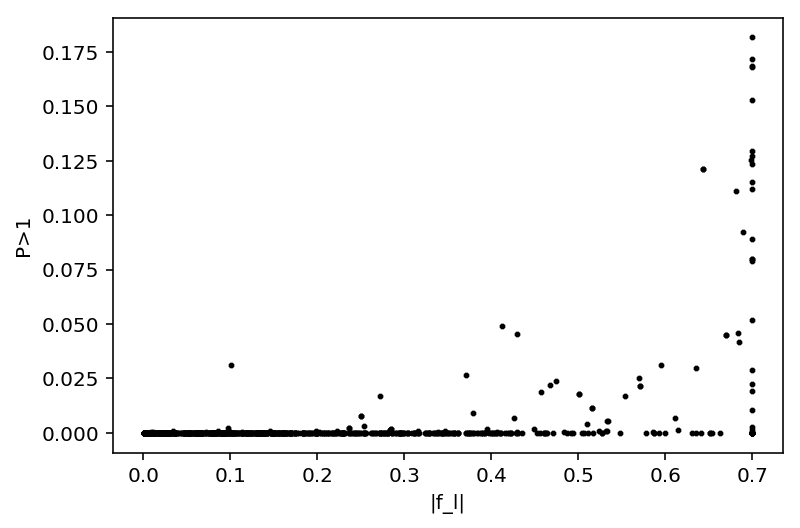

In [318]:
fig, ax = plt.subplots()



#ax.set_xscale("log")
#ax.set_yscale("log")
ax.plot(np.abs(f), p, "8", markersize=2, c="0")
ax.set_xlabel("|f_l|")
ax.set_ylabel("P>1")



Text(0, 0.5, 'P>1')

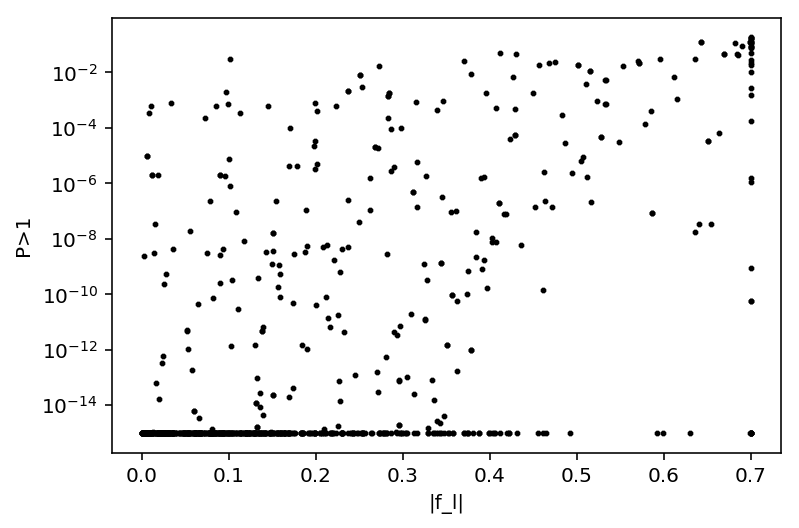

In [319]:
fig, ax = plt.subplots()



#ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(np.abs(f), (p+1e-15), "8", markersize=2, c="0")
ax.set_xlabel("|f_l|")
ax.set_ylabel("P>1")



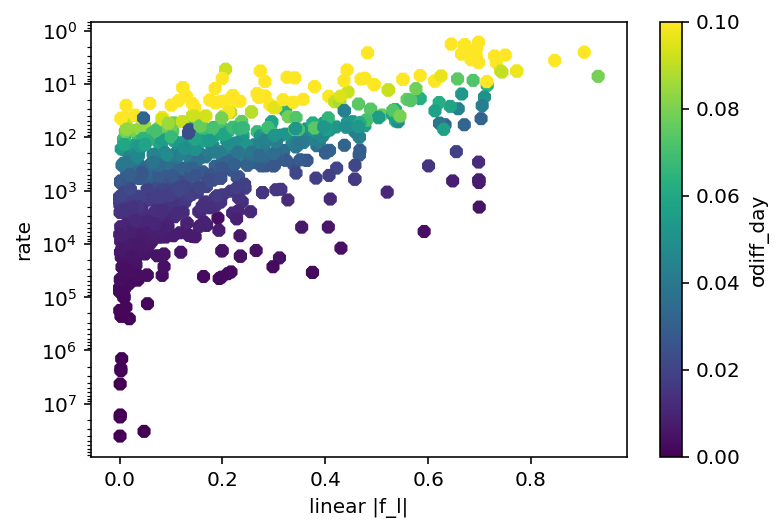

In [ ]:
fig, ax = plt.subplots()



#ax.set_xscale("log")
ax.set_yscale("log")
ax.invert_yaxis()
scat = ax.scatter(np.abs(fav_sgn.line_saturation_linear.iloc[11,:]), rate, marker="8", c=line_ratings.σdiff_day)
ax.set_xlabel("linear |f_l|")
ax.set_ylabel("rate")
#ax.set_ylim(0,2000)

scat.set_clim(0,.1)

cbar = fig.colorbar(scat,ax=ax)
cbar.set_label("σdiff_day")


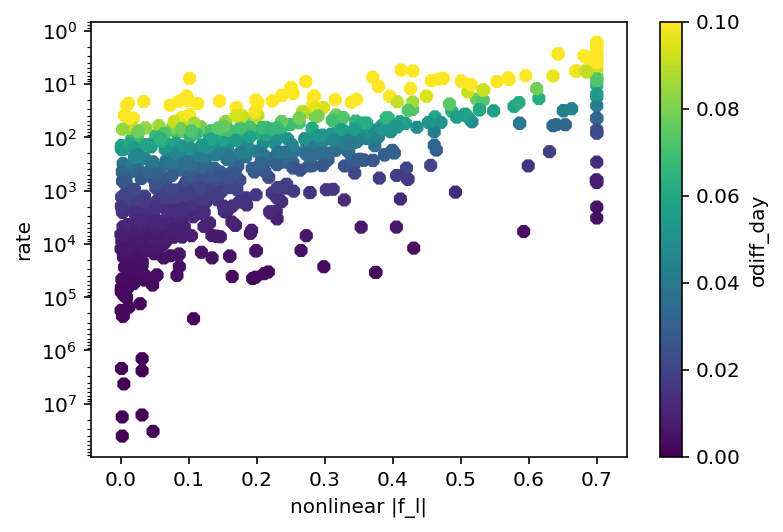

In [ ]:
fig, ax = plt.subplots()



#ax.set_xscale("log")
ax.set_yscale("log")
ax.invert_yaxis()
scat=ax.scatter(np.abs(f), rate, marker="8", c=line_ratings.σdiff_day)
ax.set_xlabel("nonlinear |f_l|")
ax.set_ylabel("rate")
#ax.set_ylim(0,2000)

scat.set_clim(0,.1)

cbar = fig.colorbar(scat,ax=ax)
cbar.set_label("σdiff_day")


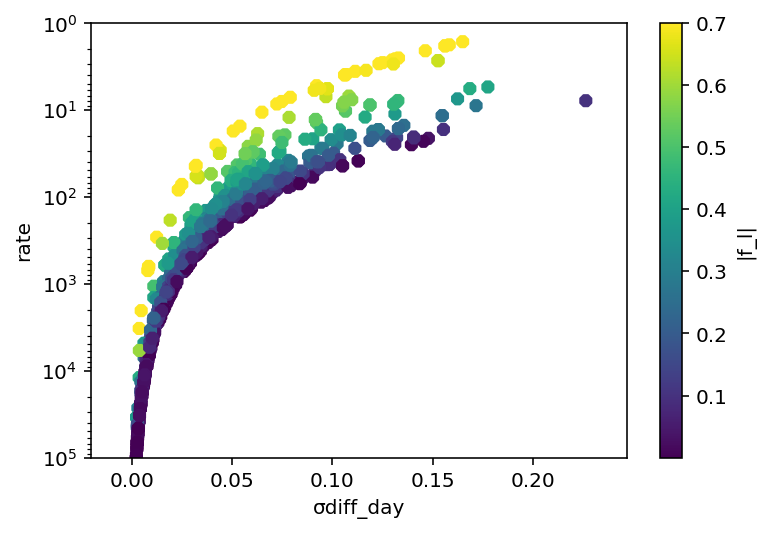

In [ ]:
fig, ax = plt.subplots()



#ax.set_xscale("log")
ax.set_yscale("log")
scat=ax.scatter(line_ratings.σdiff_day, rate, marker="8", c=np.abs(f))
ax.set_xlabel("σdiff_day")
ax.set_ylabel("rate")
ax.set_ylim(1,1e5)
ax.invert_yaxis()

cbar = fig.colorbar(scat,ax=ax)
cbar.set_label("|f_l|")

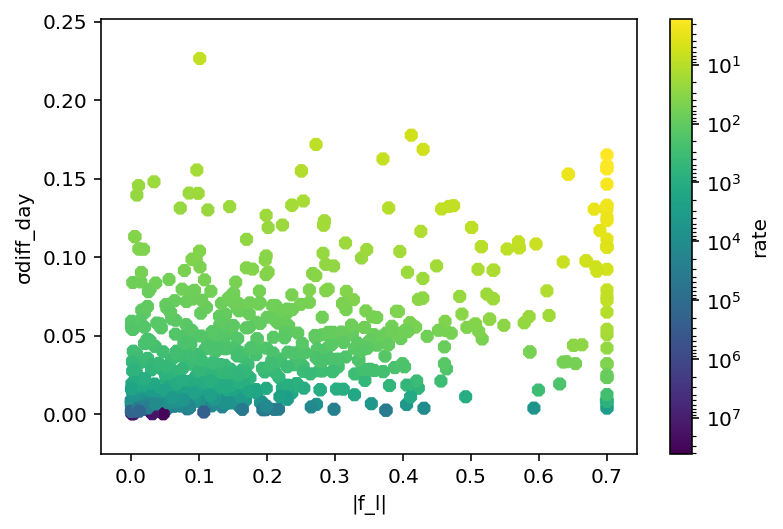

In [ ]:
import matplotlib.colors

fig, ax = plt.subplots()



#ax.set_xscale("log")
#ax.set_yscale("log")
scat=ax.scatter(np.abs(f), line_ratings.σdiff_day, marker="8", c=rate, norm=matplotlib.colors.LogNorm(), cmap="viridis_r")
ax.set_xlabel("|f_l|")
ax.set_ylabel("σdiff_day")
#ax.set_ylim(0,2000)

#ax.set_cscale("log")

cbar = fig.colorbar(scat,ax=ax)
cbar.set_label("rate")
cbar.ax.invert_yaxis()

In [ ]:
import matplotlib.colors

fig, ax = plt.subplots()



#ax.set_xscale("log")
#ax.set_yscale("log")
scat=ax.scatter(np.abs(f), line_ratings.σdiff_day, marker="8", c=(p+1e-15), norm=matplotlib.colors.LogNorm(), cmap="gist_rainbow")
ax.set_xlabel("|f_l|")
ax.set_ylabel("σdiff_day")
#ax.set_ylim(0,2000)

#ax.set_cscale("log")

cbar = fig.colorbar(scat,ax=ax)
cbar.set_label("P>1")

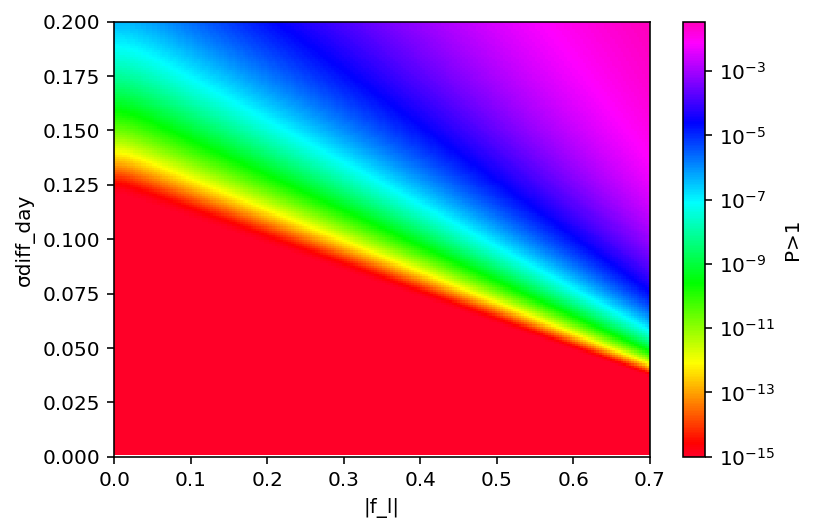

In [279]:
import matplotlib.colors

fig, ax = plt.subplots()


x = np.linspace(0,.7,num=200)
y = np.linspace(0,.2,num=200)

xx, yy = np.meshgrid(x,y)

extent = [x[0],x[-1],y[-1],y[0]]
ax.imshow(true_prob(xx,yy)+1e-15, norm=matplotlib.colors.LogNorm(), cmap="gist_rainbow", extent=extent, aspect="auto")
ax.set_xlabel("|f_l|")
ax.set_ylabel("σdiff_day")
ax.invert_yaxis()
#ax.set_ylim(0,2000)

#ax.set_cscale("log")

cbar = fig.colorbar(scat,ax=ax)
cbar.set_label("P>1")

In [270]:
true_prob(.7,.15)

0.02275013194817921

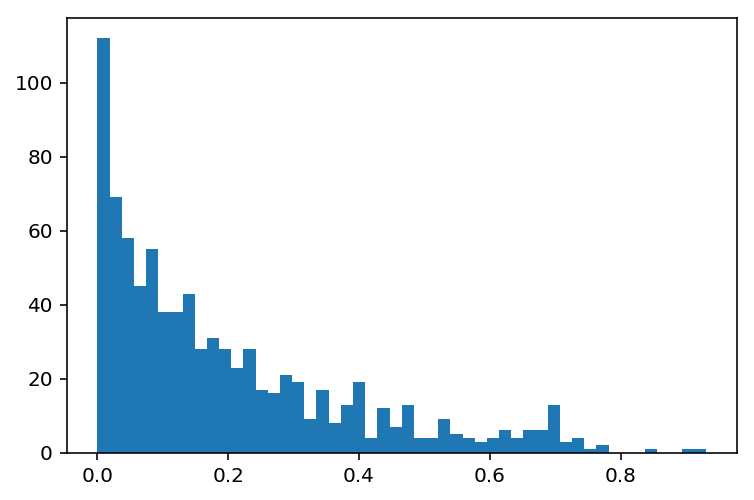

In [66]:
fig, ax = plt.subplots()

_=ax.hist(np.abs(fav_sgn.line_saturation_linear.values[11,:]), bins=50)

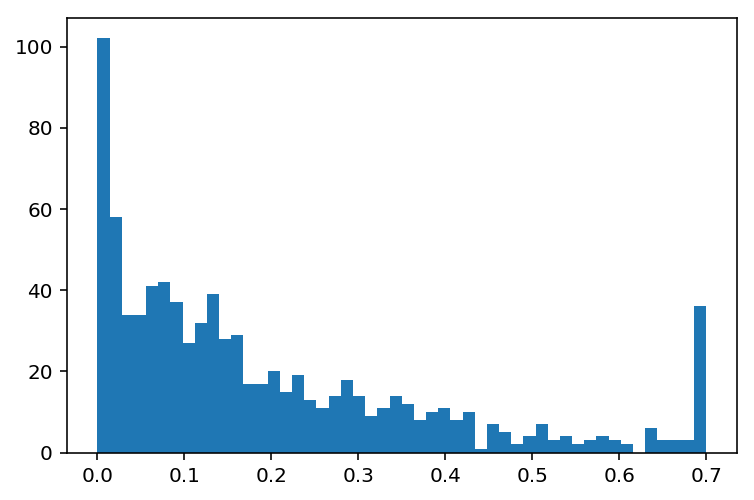

In [74]:
fig, ax = plt.subplots()

sgn.line_saturation_nonlinear = sgn.line_flow_nonlinear / sgn.line_threshold

_=ax.hist(np.abs(fav_sgn.line_saturation_nonlinear.values[11,:]), bins=50)

# Bus covariance matrix

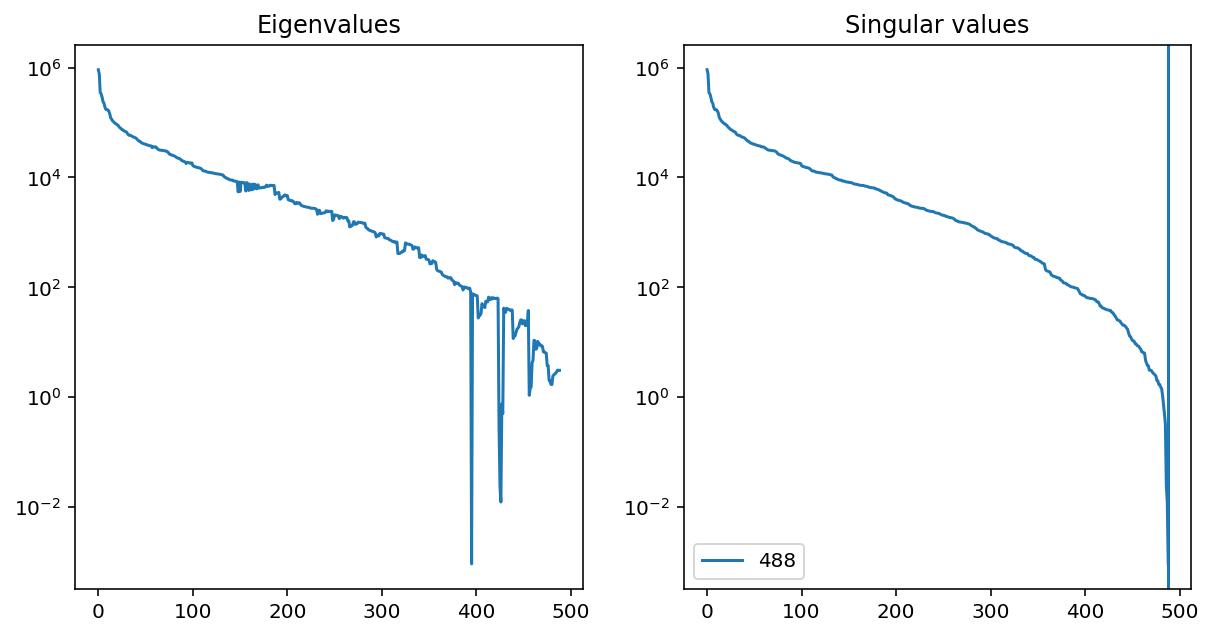

In [641]:
c = bus_diff_cov_day.copy()
c += np.diag(np.diag(c)) * 32

eig=np.linalg.eig(c)[0]
svd=np.linalg.svd(c)[1]
#z=np.linalg.svd(sgn.F)

printm("# Bus covariance matrix")

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(eig)
ax[0].set_yscale("log")
ax[0].set_title("Eigenvalues")
ax[1].plot(svd)
ax[1].set_yscale("log")
ax[1].set_title("Singular values")

ax[1].axvline(np.argmin(svd), label=str(np.argmin(svd)))
ax[1].legend()

# Line covariance matrix

Text(0.5, 1.0, 'Singular values')

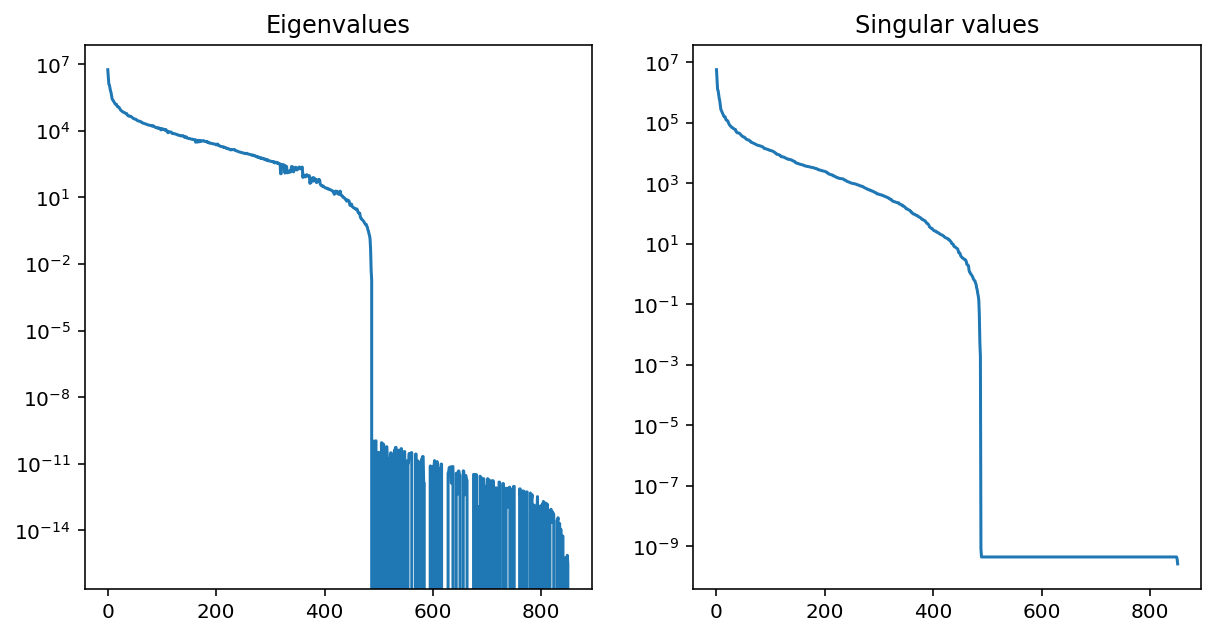

In [644]:
eig=np.linalg.eig(fav_sgn.F @ c @ fav_sgn.F.T)[0]
svd=np.linalg.svd(fav_sgn.F @ c @ fav_sgn.F.T)[1]
#z=np.linalg.svd(sgn.F)

printm("# Line covariance matrix")

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(eig)
ax[0].set_yscale("log")
ax[0].set_title("Eigenvalues")
ax[1].plot(svd)
ax[1].set_yscale("log")
ax[1].set_title("Singular values")


# LPF matrix

Text(0.5, 1.0, 'Singular values')

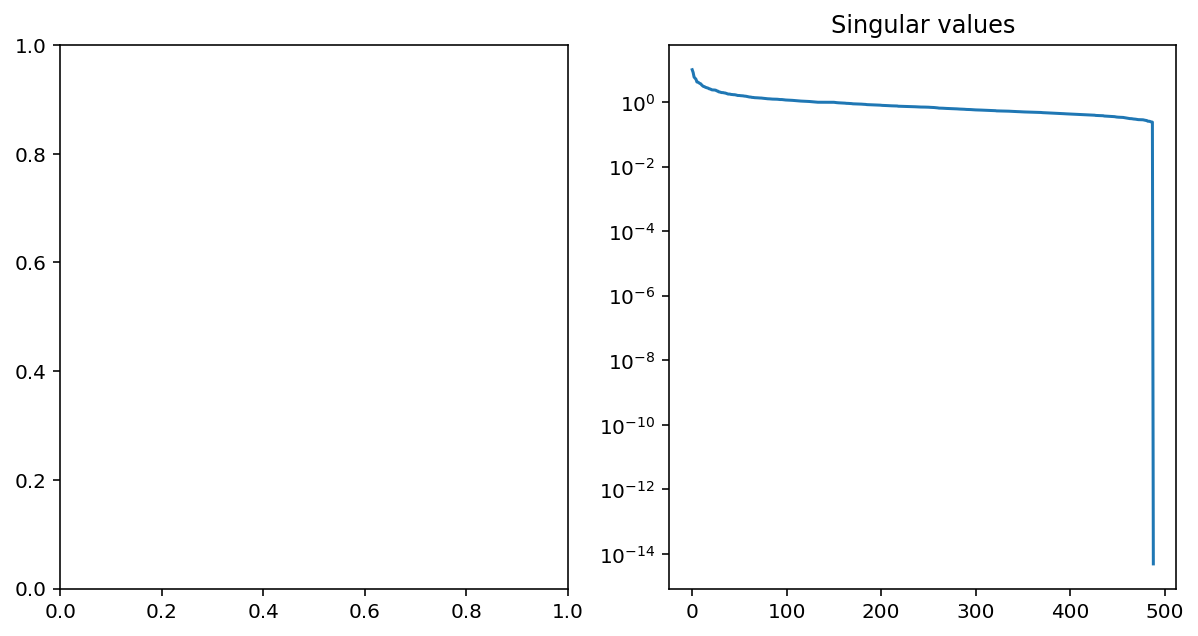

In [562]:
svd=np.linalg.svd(fav_sgn.F)[1]
#z=np.linalg.svd(sgn.F)

printm("# LPF matrix")

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[1].plot(svd)
ax[1].set_yscale("log")
ax[1].set_title("Singular values")


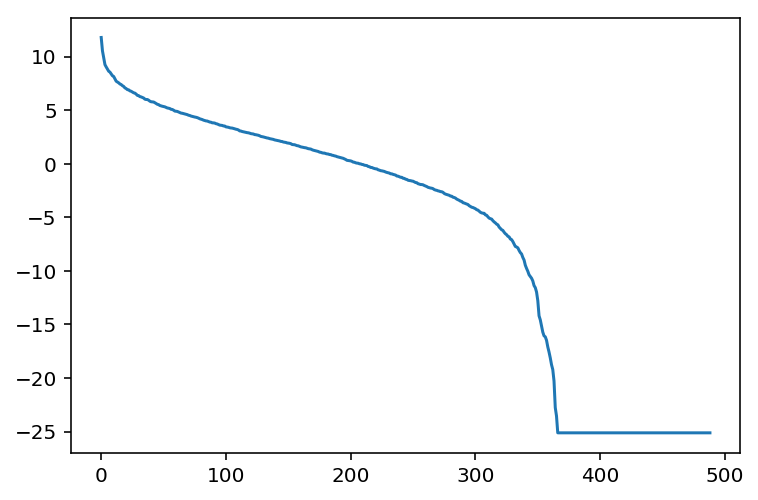

In [554]:
z=np.linalg.svd(bus_diff_cov_day)

#z=np.linalg.svd(sgn.F)
plt.plot(np.log(np.abs(z[1])))

In [553]:
sum(sgn.network.generators.source == "Wind Onshore")

488

In [407]:
s=sgn.solar_generation.sum(axis=1)
#pd.DataFrame({"generation":s, "cov:":np.diagonal(bus_diff_cov_day)})

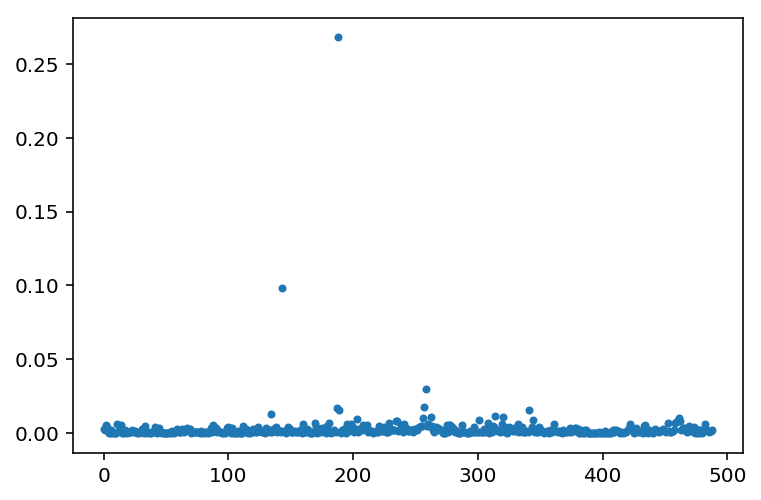

In [385]:
fig, ax = plt.subplots()

ax.plot(np.diagonal(bus_diff_cov_day) / s, ".")

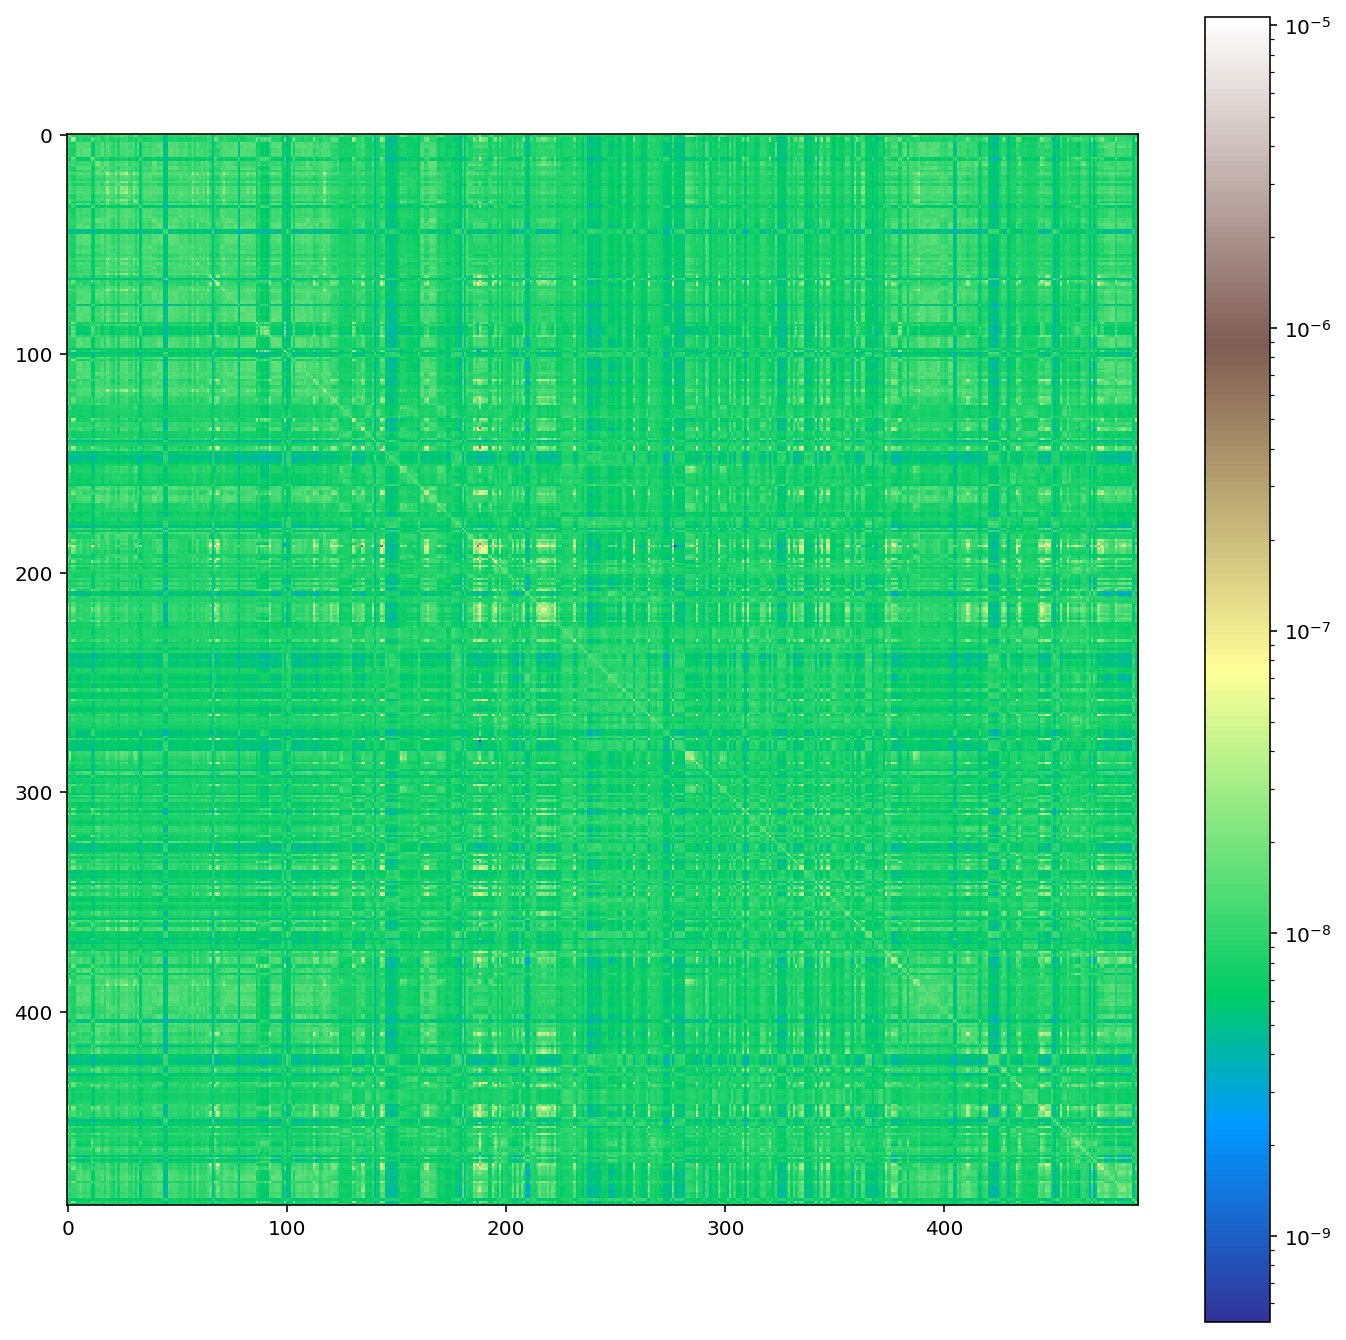

In [387]:
fig, ax = plt.subplots(figsize=(12,12))

sx, sy = np.meshgrid(s,s)

um=ax.imshow(bus_diff_cov_day /sx /sy, cmap="terrain", norm=matplotlib.colors.LogNorm())

fig.colorbar(um, ax=ax)

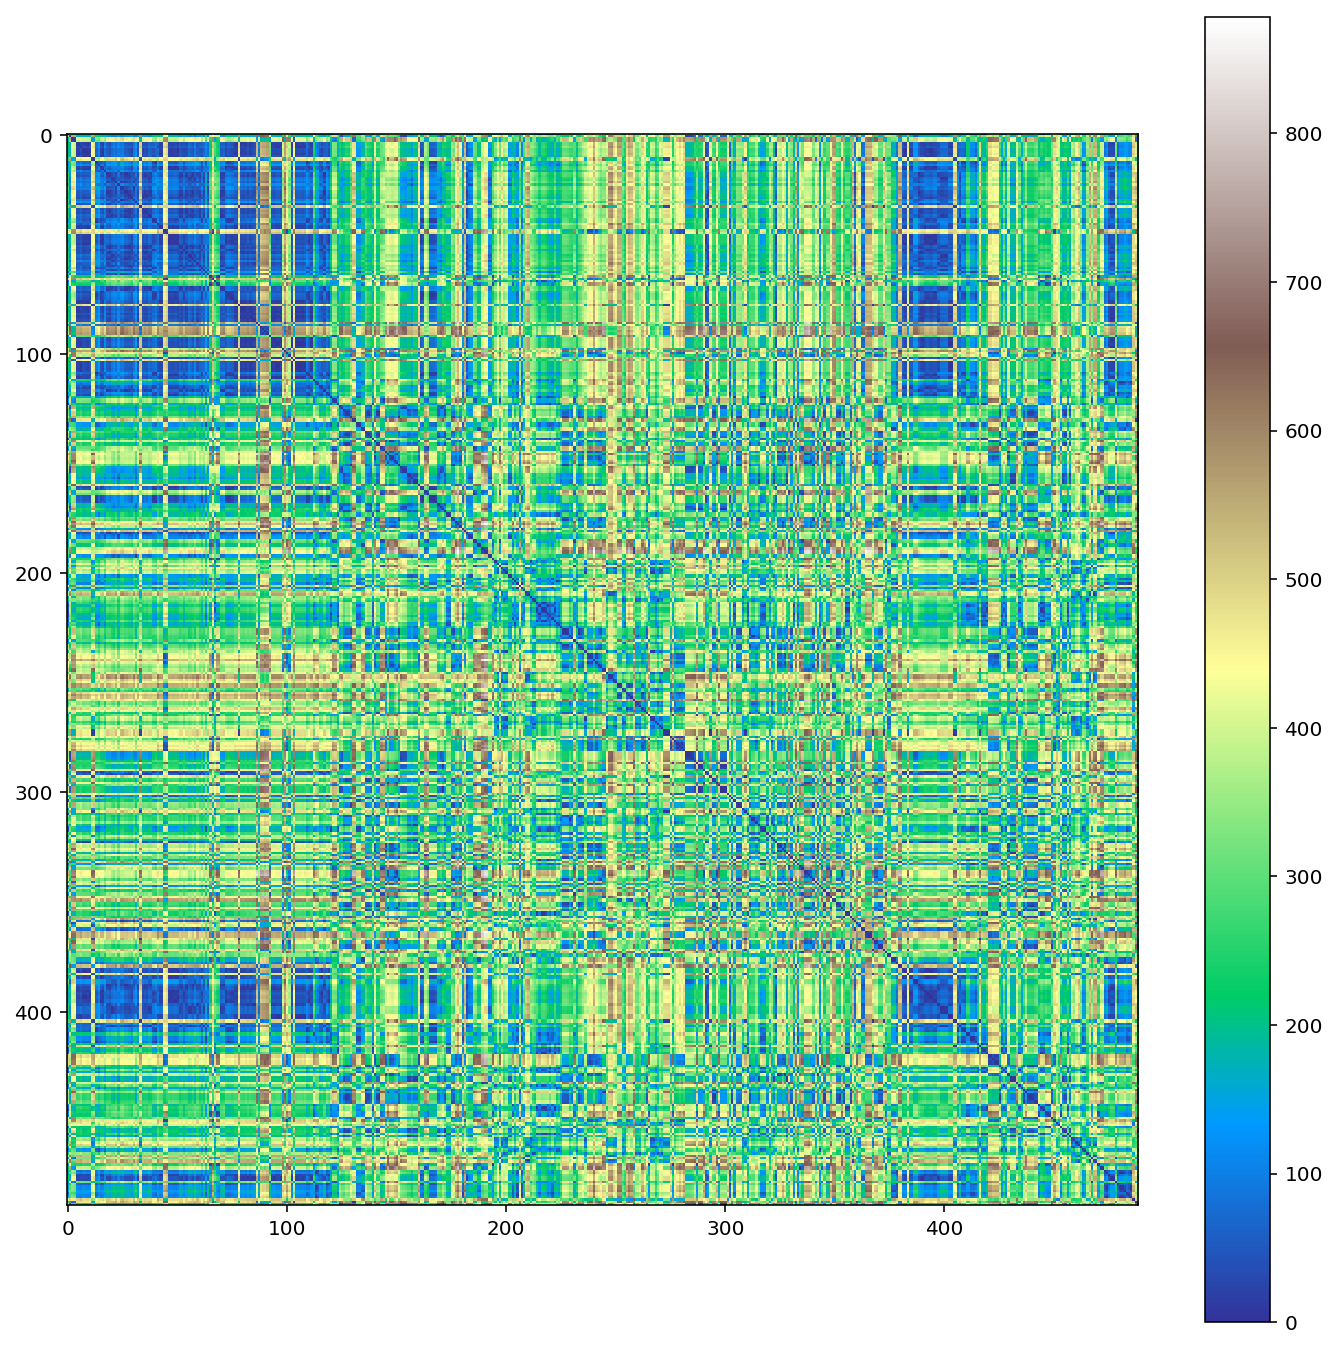

In [406]:
fig, ax = plt.subplots(figsize=(12,12))
distmat = sgn.get_dist_matrix()

um=ax.imshow(distmat, cmap="terrain")

fig.colorbar(um, ax=ax)

Text(0, 0.5, 'Covariance')

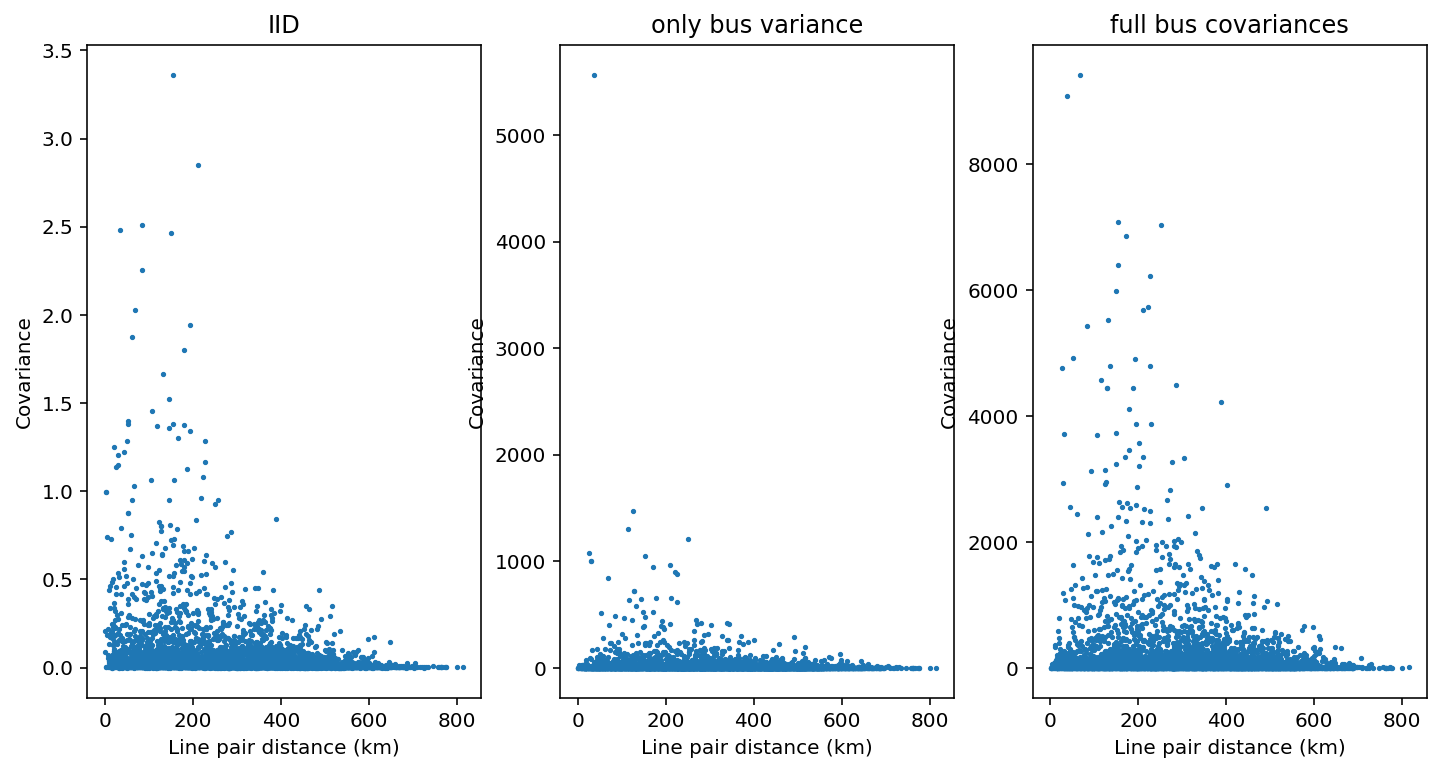

In [727]:
num_line_pairs = 5000

pairs = zip(np.random.choice(range(fav_sgn.m), size=num_line_pairs), np.random.choice(range(fav_sgn.m), size=num_line_pairs))
pairs = list(pairs)

import itertools

def linedist(l, m):
    return sum(itertools.starmap(fav_sgn.dist, itertools.product(fav_sgn.new_lines[l], fav_sgn.new_lines[m]))) / 4


no_var = fav_sgn.F @ fav_sgn.F.T
no_cov = fav_sgn.F @ np.diag(np.diag(bus_diff_cov_night)) @ fav_sgn.F.T


pair_covs = np.array([line_diff_cov_night[p] for p in pairs])
pair_no_vars = np.array([no_var[p] for p in pairs])
pair_no_covs = np.array([no_cov[p] for p in pairs])
#pair_covs = np.array([line_diff_cov_day[p] for p in pairs])
pair_dists = np.array([linedist(*p) for p in pairs])
#pair_thresholds = np.array([fav_sgn.line_threshold[a]*fav_sgn.line_threshold[b] for a,b in pairs]) / 100000
#pair_admittances = np.array([fav_sgn.i_times_lineadmittance[a]*fav_sgn.i_times_lineadmittance[b] for a,b in pairs])
#pair_radii = np.array([linedist(a,200)*linedist(b,200) for a,b in pairs])


fig, ax = plt.subplots(1,3, figsize=(12,6))

uh=ax[0].scatter(pair_dists, np.abs(pair_no_vars), marker="8", s=3)
uh=ax[1].scatter(pair_dists, np.abs(pair_no_covs), marker="8", s=3)
uh=ax[2].scatter(pair_dists, np.abs(pair_covs), marker="8", s=3)

ax[0].set_title("IID")
ax[1].set_title("only bus variance")
ax[2].set_title("full bus covariances")

ax[0].set_xlabel("Line pair distance (km)")
ax[1].set_xlabel("Line pair distance (km)")
ax[2].set_xlabel("Line pair distance (km)")
ax[0].set_ylabel("Covariance")
ax[1].set_ylabel("Covariance")
ax[2].set_ylabel("Covariance")

#fig.colorbar(uh, ax=ax)

#ax[0].set_ylim(0, 50)
#ax[1].set_ylim(0, 1000)
#ax.set_yscale("log")

c:\dev\grid-analysis\venvwin\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning:

invalid value encountered in true_divide



Text(0.5, 1.0, 'double bus covariances')

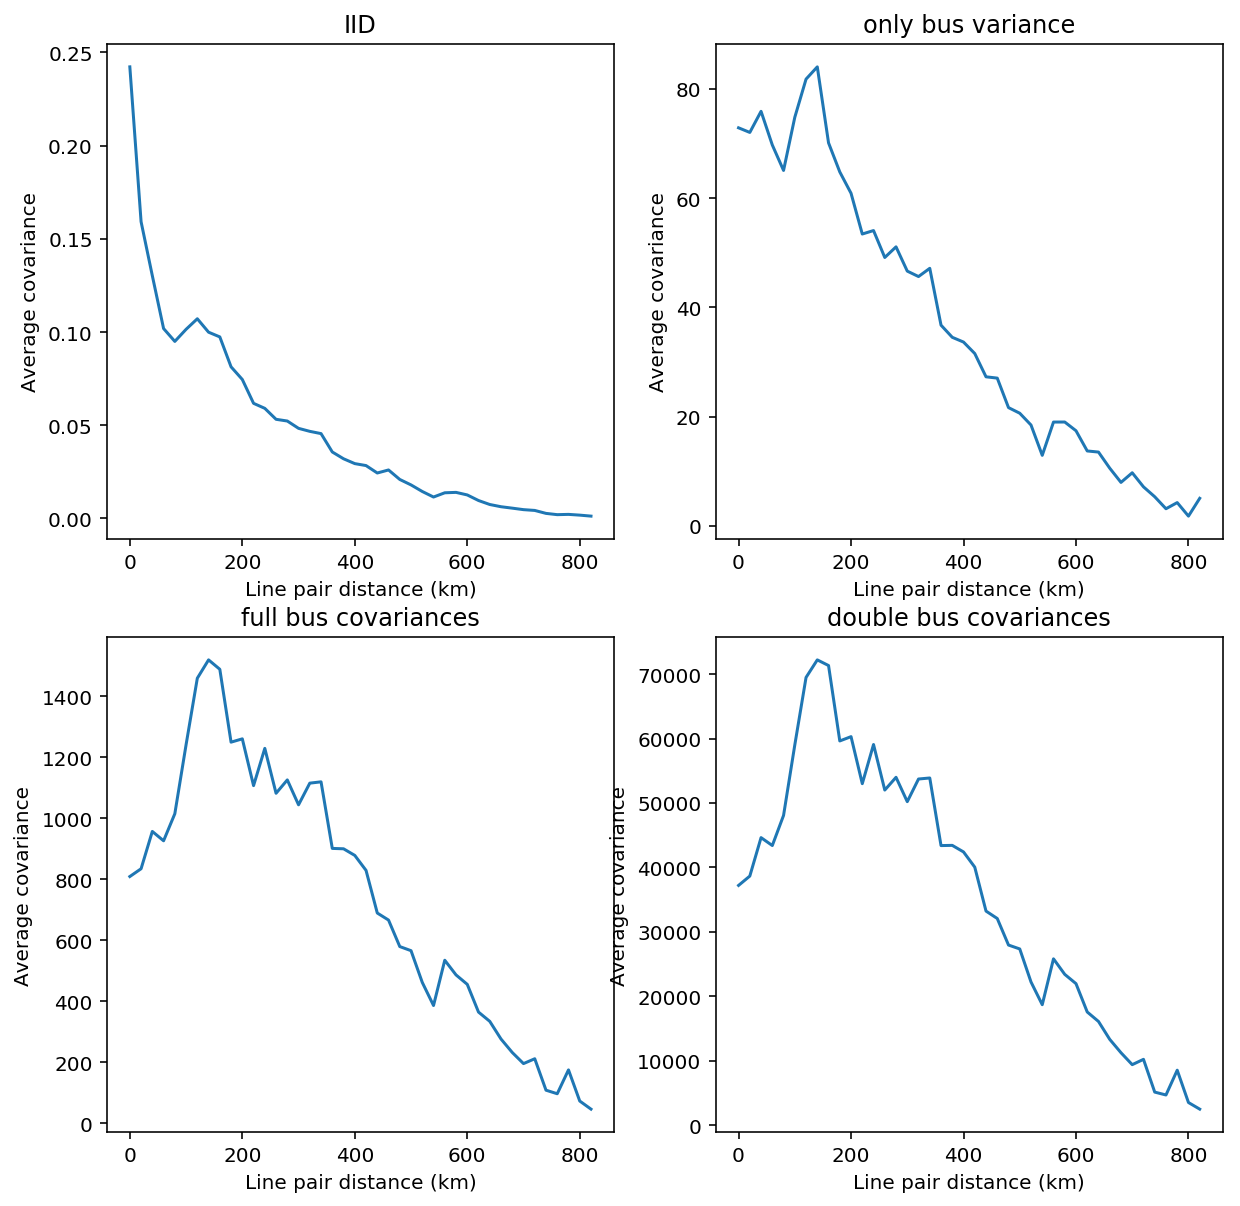

In [103]:
num_line_pairs = 100000

#pairs = zip(np.random.choice(range(fav_sgn.m), size=num_line_pairs), np.random.choice(range(fav_sgn.m), size=num_line_pairs))
#pairs = list(pairs)

import itertools

#bus_dist = fav_sgn.get_dist_matrix()

def linedist(l, m):
    return sum(itertools.starmap(bus_dist.item, itertools.product(fav_sgn.new_lines[l], fav_sgn.new_lines[m]))) / 4


no_var = fav_sgn.F @ fav_sgn.F.T
no_cov = fav_sgn.F @ np.diag(np.diag(bus_diff_cov_day)) @ fav_sgn.F.T
full_cov = fav_sgn.F @ bus_diff_cov_day @ fav_sgn.F.T
more_cov = 50.0 * line_diff_cov_day - 49.0 * no_cov

pair_dists = np.array([linedist(*p) for p in pairs])
#pair_thresholds = np.array([fav_sgn.line_threshold[a]*fav_sgn.line_threshold[b] for a,b in pairs]) / 100000
#pair_admittances = np.array([fav_sgn.i_times_lineadmittance[a]*fav_sgn.i_times_lineadmittance[b] for a,b in pairs])
#pair_radii = np.array([linedist(a,200)*linedist(b,200) for a,b in pairs])


bins = np.arange(0,900,20)

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flatten()

for i, line_covs in enumerate([no_var, no_cov, full_cov, more_cov]):
    pair_covs = np.array([line_covs[p] for p in pairs])
    nums, _ = np.histogram(pair_dists, bins=bins)
    sums, _ = np.histogram(pair_dists, weights=np.abs(pair_covs), bins=bins)
    ax[i].plot(bins[:-1], sums/nums)
    ax[i].set_xlabel("Line pair distance (km)")
    ax[i].set_ylabel("Average covariance")



#uh=ax[0].scatter(pair_dists, np.abs(pair_no_vars), marker="8", s=3)
#uh=ax[1].scatter(pair_dists, np.abs(pair_no_covs), marker="8", s=3)
#uh=ax[2].scatter(pair_dists, np.abs(pair_covs), marker="8", s=3)

ax[0].set_title("IID")
ax[1].set_title("only bus variance")
ax[2].set_title("full bus covariances")
ax[3].set_title("double bus covariances")

#fig.colorbar(uh, ax=ax)

#ax[0].set_ylim(0, 50)
#ax[1].set_ylim(0, 1000)
#ax.set_yscale("log")

c:\dev\grid-analysis\venvwin\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in true_divide



# $10^5$ random line pairs

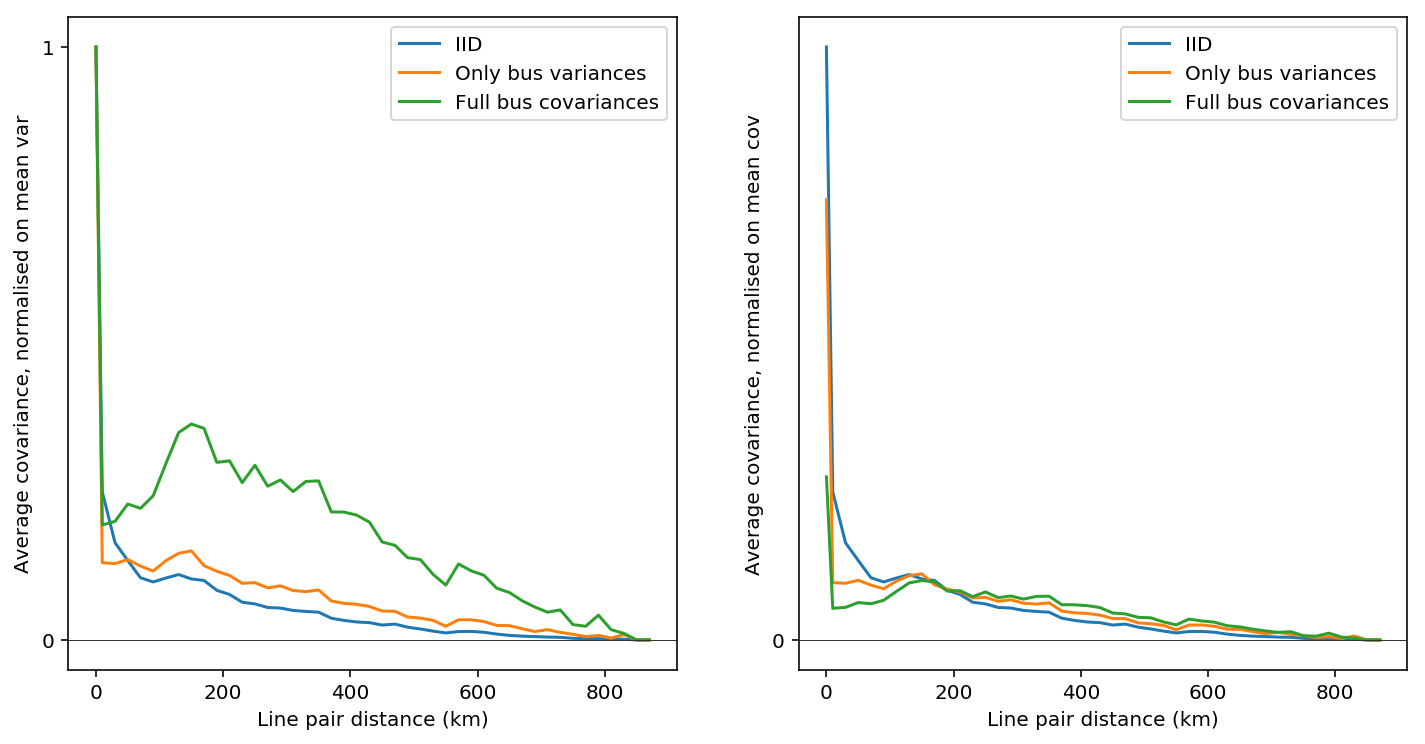

In [133]:
bins = np.arange(0,900,20)

fig, ax = plt.subplots(1,2,figsize=(12,6))

for i, (line_covs, name) in enumerate([(no_var, "IID"), (no_cov, "Only bus variances"), (full_cov, "Full bus covariances")]):
    pair_covs = np.array([line_covs[p] for p in pairs])
    nums, _ = np.histogram(pair_dists, bins=bins)
    sums, _ = np.histogram(pair_dists, weights=np.abs(pair_covs), bins=bins)
    
    avg_var = np.mean(np.diag(line_covs))
    
    x = (bins[1:]+bins[:-1])/2
    y = sums/nums
    y[np.isnan(y)] = 0
    ax[0].plot([0] + list(x), [1] + list(y / avg_var), label=name)
    ax[1].plot([0] + list(x), [avg_var / np.mean(y)] + list(y / np.mean(y)), label=name)
#     ax[2].plot(x, y / y[0], label=name)
#     ax[2].set_xlabel("Line pair distance (km)")
#     ax[2].set_ylabel("Average covariance, normalised")


ax[0].legend()
ax[1].legend()

#fig.colorbar(uh, ax=ax)

#ax[0].set_ylim(0, 50)
#ax[1].set_ylim(0, 1000)
#ax.set_yscale("log")
ax[0].set_xlabel("Line pair distance (km)")
ax[0].set_ylabel("Average covariance, normalised on mean var")
ax[1].set_xlabel("Line pair distance (km)")
ax[1].set_ylabel("Average covariance, normalised on mean cov")

ax[0].axhline(0,color="#333333",linewidth=.5)
ax[1].axhline(0,color="#333333",linewidth=.5)

ax[0].yaxis.set_ticks([0,1])
ax[1].yaxis.set_ticks([0])

printm("# $10^5$ random line pairs")

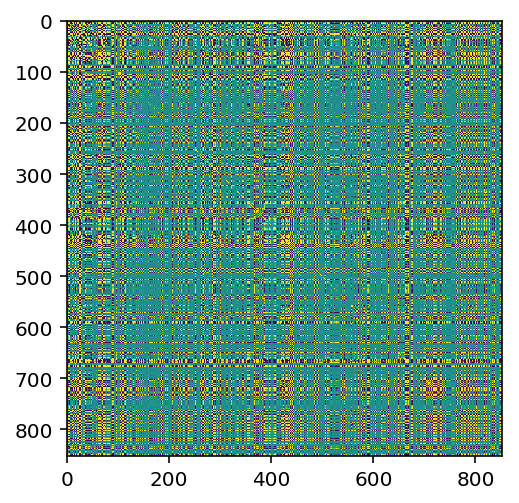

In [537]:
plt.imshow(no_cov, vmin=-10, vmax=10)

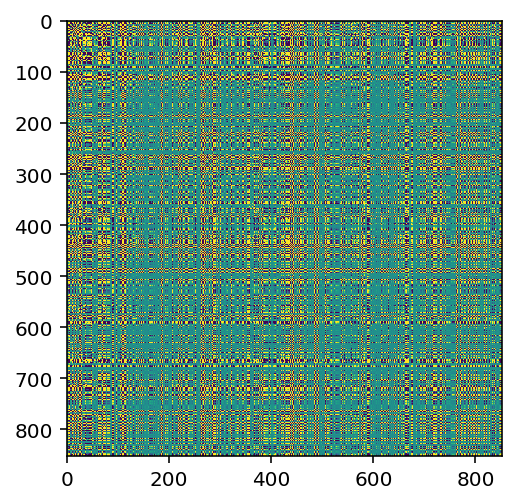

In [538]:
plt.imshow(line_diff_cov_night, vmin=-100, vmax=100)

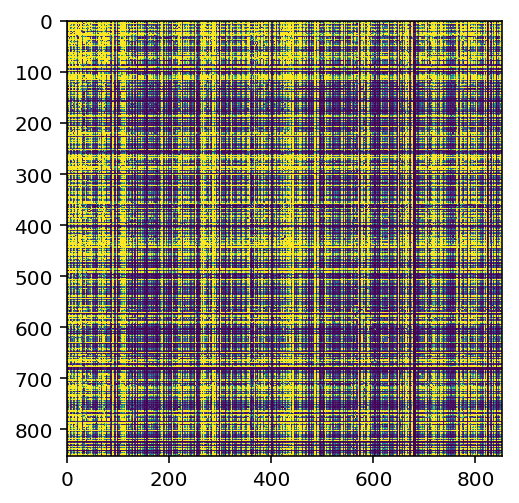

In [622]:
plt.imshow(np.abs(line_diff_cov_night),vmax=100)

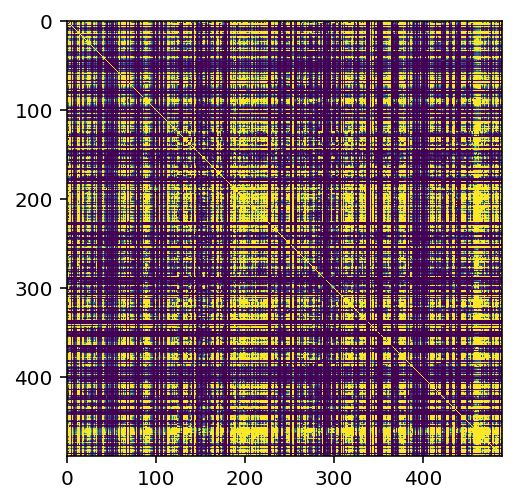

In [634]:
c = bus_res_cov_night

c += np.diag(np.diag(c))*32

plt.imshow(np.abs(c), vmax=1)#, vmin=-100, vmax=100)

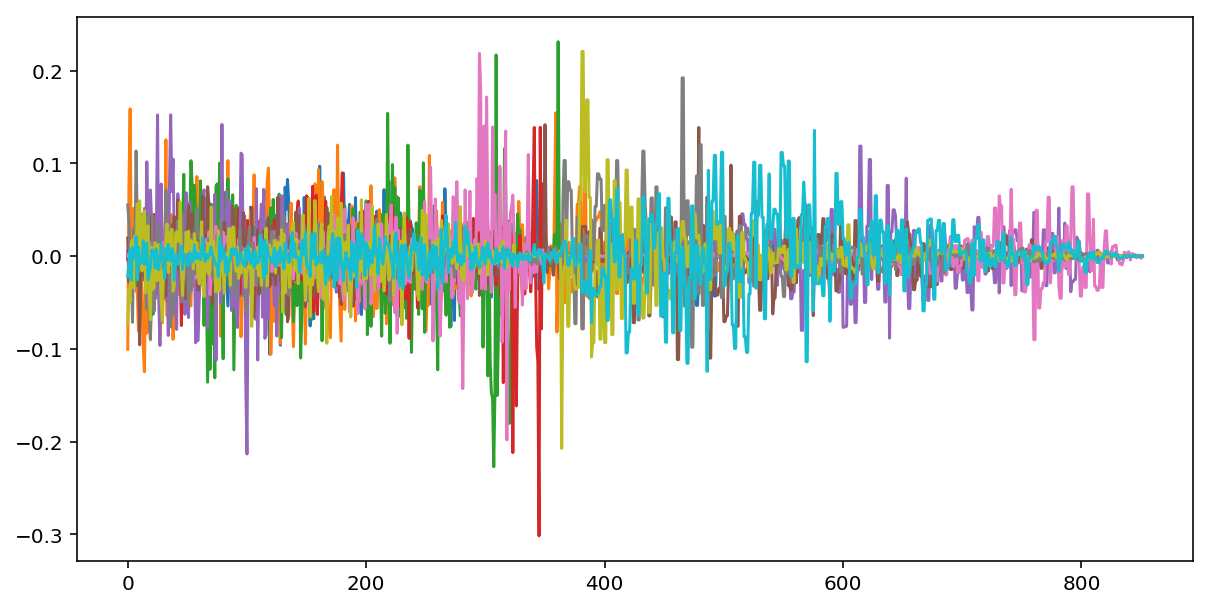

In [598]:
fig, ax = plt.subplots(figsize=(10,5))

z = np.linalg.eig(line_diff_cov_day)
for i in range(0,100,10):
    ax.plot(z[1][i,:])
#z[0][0,:]

(<matplotlib.collections.PathCollection at 0x22626ae13c8>,
 <matplotlib.collections.LineCollection at 0x22626ae17b8>)

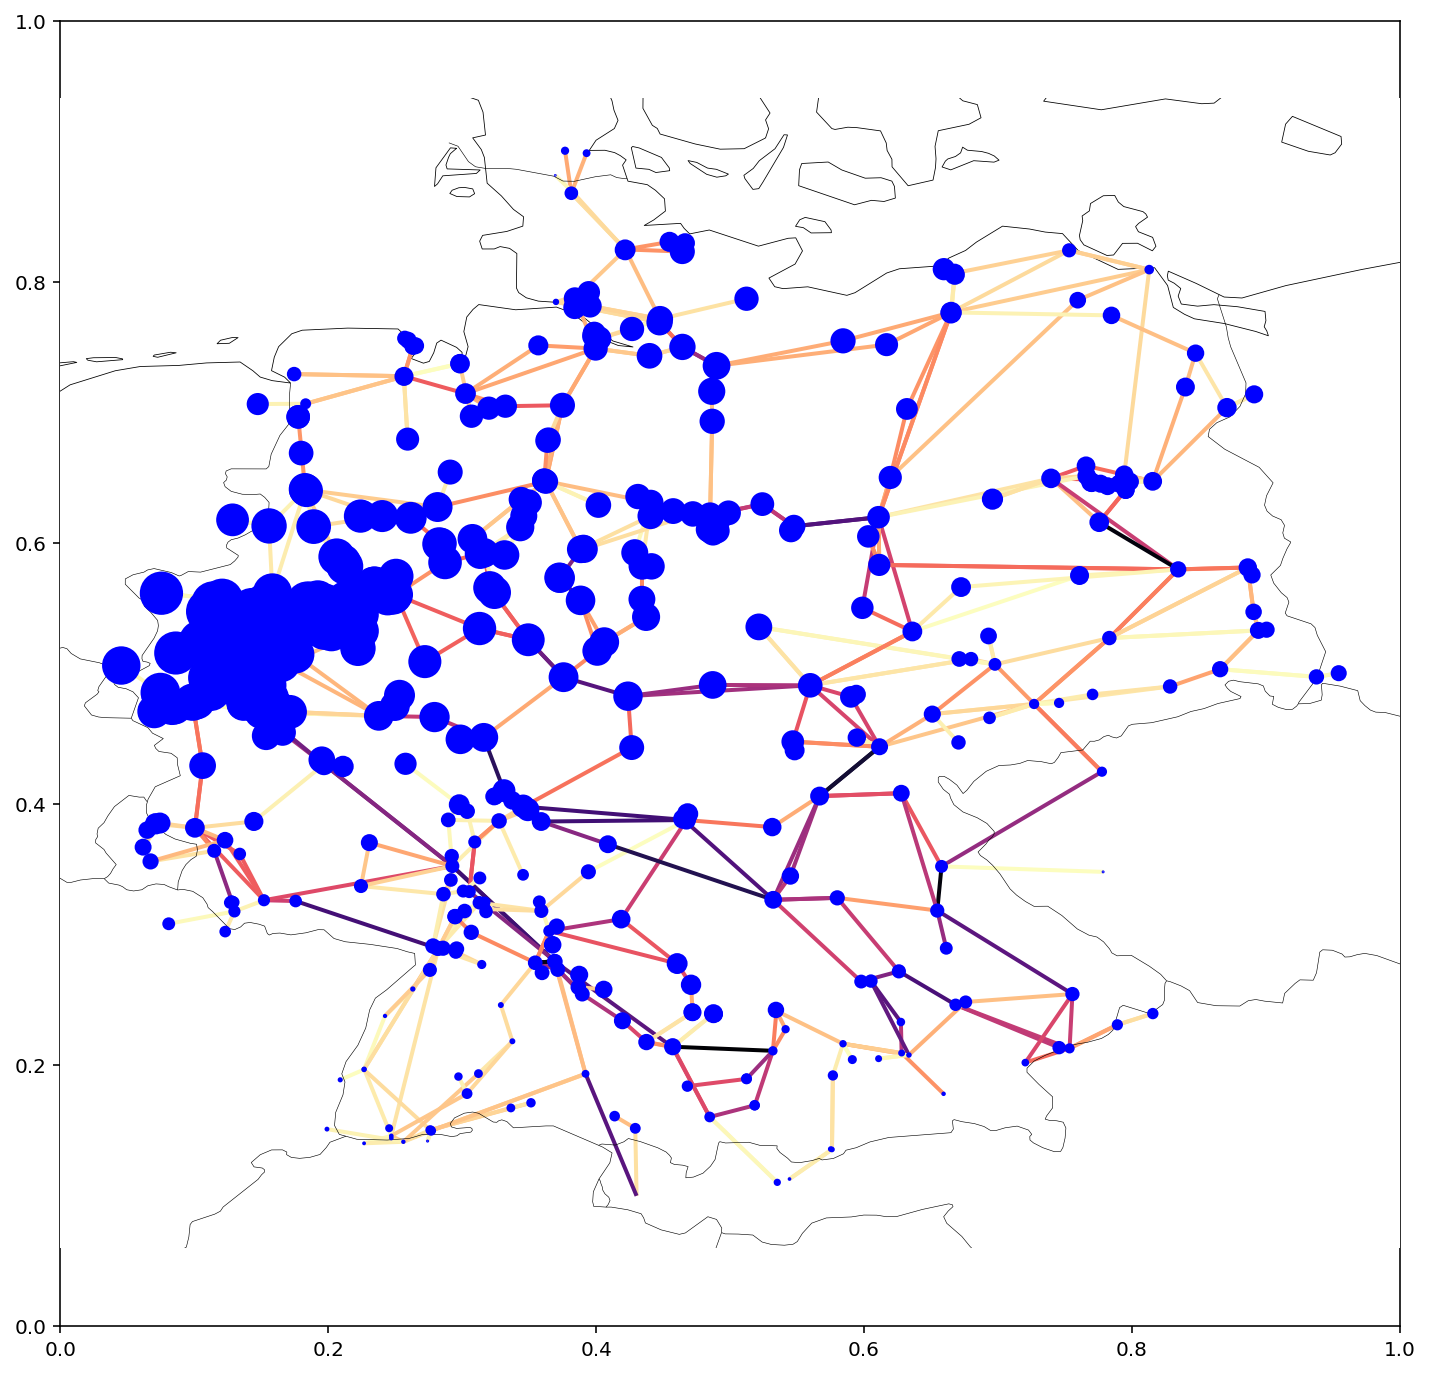

In [671]:
fig, ax = plt.subplots(figsize=(12,12))


bus_sizes = [0]*len(fav_sgn.network.buses)
bus_colors = ['g']*len(fav_sgn.network.buses)

for i, bus_name in enumerate(fav_sgn.network.buses.index):
    if bus_name in fav_sgn.new_nodes:
        powerinj = (wind_diff_cov_norm[390])[fav_sgn.node_index(bus_name)]
        bus_sizes[i] = np.abs(powerinj) * 100000
        bus_colors[i] = 'g' if powerinj > 0 else 'y'


fav_sgn.network.plot(basemap=True, bus_sizes=bus_sizes, line_colors=np.abs(line_diff_cov_day[555])/fav_sgn.line_threshold, line_cmap="magma_r")
#fav_sgn.network.plot(basemap=True, bus_sizes=0, line_colors=range(fav_sgn.m), line_cmap="magma_r")

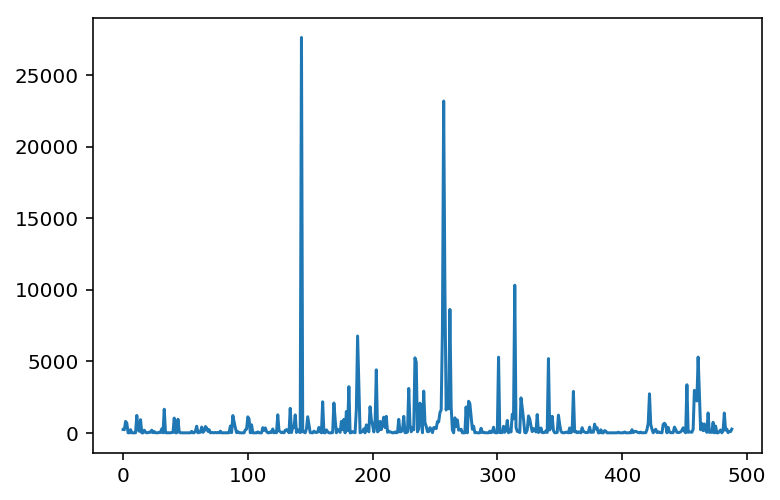

In [141]:
fig, ax = plt.subplots()
ax.plot(np.diag(bus_diff_cov_day))
#ax.set_yscale("log")

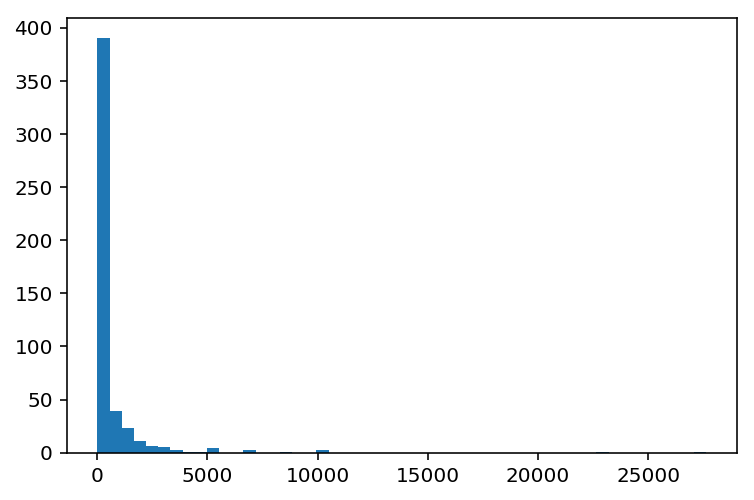

In [138]:
_=plt.hist(np.diag(bus_diff_cov_day), bins=50)

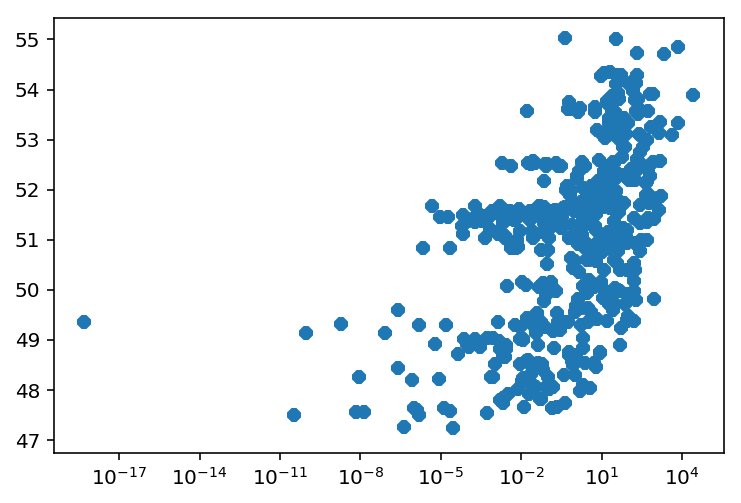

In [150]:
fig, ax = plt.subplots()

latitudes = fav_sgn.locations.y

ax.plot(np.diag(wind_diff_cov), latitudes, "8")
ax.set_xscale("log")